Now that I've figured out morphing DR7 spectra, apply it to the much bigger DR14 sample where it will actually be useful.  Ideally in this notebook the larger training set from DR14 will lead to better reconstruction -- as well as more interpretable "latent parameters".

In [2]:
from tensorflow import keras
#import keras

from astropy.io import fits
from astropy.table import Table
from astropy.io.fits import Column
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import richardsplot
import os

In [3]:
import tensorflow as tf
np.__version__, tf.__version__, keras.__version__

('1.19.1', '1.12.0', '2.1.6-tf')

In [4]:
#path = "/Users/trevormccaffrey/Desktop/Research/GTR/Cosmo/ML/data/"
path = "/Users/trevormccaffrey/Desktop/Research/GTR/VLA2018b/"

In [5]:
#Now we're working with dr14 only at 1.627 < z < 2.088, so use this new datafram from hereon
dat = pd.read_csv("~/Desktop/Research/GTR/Cosmo/ML/data/DR14_zmin162_zmax208.csv")
dat.head()

Unnamed: 0              SDSS_NAME        RA        DEC   THING_ID  PLATE  \
0          10  b'000001.56+203011.5'  0.006523  20.503197  290594773   7596   
1          19  b'000002.15+151516.6'  0.008980  15.254639  246765254   6172   
2          20  b'000002.19-021947.2'  0.009139  -2.329783   59825899   7850   
3          26  b'000002.97+225645.9'  0.012415  22.946096  311303506   7665   
4          28  b'000003.18+050822.3'  0.013254   5.139552  155964498   8740   

     MJD  FIBERID  SPECTRO         Z  ...         JFLUX     JFLUX_ERR  \
0  56945      821  b'BOSS'  2.083215  ...  0.000000e+00  0.000000e+00   
1  56269      394  b'BOSS'  1.710000  ...  2.910325e-31  4.694344e-32   
2  56956      339  b'BOSS'  1.966623  ...  0.000000e+00  0.000000e+00   
3  57328      452  b'BOSS'  1.759105  ...  0.000000e+00  0.000000e+00   
4  57367      340  b'BOSS'  1.801677  ...  1.431263e-31  4.114480e-32   

          HFLUX     HFLUX_ERR         KFLUX     KFLUX_ERR  FIRST_MATCHED  \
0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00             -1   
1  1.572201e-31  5.927228e-32  1.538285e-31  6.478741e-32             -1   
2  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00              0   
3  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00             -1   
4  8.260369e-32  4.348945e-32  2.371781e-31  5.186590e-32              0   

   FIRST_FLUX  FIRST_SNR  SDSS2FIRST_SEP  
0        -1.0       -1.0            -1.0  
1        -1.0       -1.0            -1.0  
2        -1.0       -1.0            -1.0  
3        -1.0       -1.0            -1.0  
4        -1.0       -1.0            -1.0  

[5 rows x 97 columns]

In [6]:
sdss_names = dat[["SDSS_NAME"]].values.flatten()
z     = dat[["Z"]].values.flatten()
plate = dat[["PLATE"]].values.flatten()
mjd   = dat[["MJD"]].values.flatten()
fiber = dat[["FIBERID"]].values.flatten()
BAL   = dat[["BI_CIV"]].values.flatten()!=0

In [7]:
spec_path = "/Users/trevormccaffrey/Desktop/Research/GTR/Cosmo/ML/data/CIV_to_MgII/lite/"

In [ ]:
#Will want to save homogeneous arrays of each QSO's wavelength, flux, and inverse variance
names   = []
spectra = []
wave    = []
ivar    = []
found   = [] #save dataframe indices which have spectra
BAL_list= []
N = 0

for sdss_name, red, pl, mj, fib, bal in zip(sdss_names, z, plate, mjd, fiber, BAL):
    try:
        hdul_spec = fits.open(spec_path+"%04d/spec-%04d-%05d-%04d.fits" % (pl,pl,mj,fib))
    except FileNotFoundError:
        #print(spec_path+"%04d/spec-%04d-%05d-%04d.fits NOT FOUND" % (pl,pl,mj,fib))
        continue
        
        
    #Load in data from each FITS file
    sdss_flux   = hdul_spec[1].data["flux"]
    sdss_loglam = hdul_spec[1].data["loglam"]
    sdss_wave   = 10.**(sdss_loglam) / (1+red)  #x-axis: wavelength
    sdss_ivar   = hdul_spec[1].data["ivar"]
    
    #Want the same wavelength range for each array
    wavemask   = ((sdss_wave>=1443) & (sdss_wave<=2961))
    sdss_flux  = sdss_flux[wavemask]
    #sdss_flux /= np.median(sdss_flux) #normalize spectrum
    sdss_ivar  = sdss_ivar[wavemask]
    sdss_wave  = sdss_wave[wavemask]
    hdul_spec.close()
    
    if len(sdss_flux) >= 3121:
        names.append(sdss_name)
        spectra.append(sdss_flux[:3121])
        wave.append(sdss_wave[:3121])
        ivar.append(sdss_ivar[:3121])
        found.append(N)
        if bal: BAL_list.append(bal)

    N+=1
    if N%5000==0: print(N)  
    #if N>100: break
    
spectra = np.array(spectra)
wave    = np.array(wave)
ivar    = np.array(ivar)
found = np.array(found)

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000


In [ ]:
spectra.shape

----

Now that all spectra are loaded in the desired format, set up the morphing.  See ``autoencoder4_morphing.ipynb`` for how the reference array was obtained.

In [ ]:
#Get the normed data
morph_norm = np.load("/Users/trevormccaffrey/Desktop/git/Cosmology_Quasars/morph_ref_DR7mean_normed.npy")
spectra_normed = spectra / np.nanmedian(spectra, axis=1)[:, np.newaxis]
spectra_normed.shape

We'll use this "baby NN" (trained on DR7 spectra) to get reconstructions which will provide the "general shapes" of the spectra which we can then morph; the actual quality of the reconstructions is not much of a concern right now.

In [ ]:
#Create the preliminary reconstructions to determine morphing; using reconstructions ignores absorption (mostly)
import tensorflow.keras.backend as K
MASKK= (~((wave[0]>1490)&(wave[0]<1546))).astype(int) #Mask CIV absorption
MASK = K.variable(MASKK)

#Build the autoencoder architecture (keras.models.load_model has all sorts of dependency issues between diff versions of tf)
morph_encoder = keras.models.Sequential([
    keras.layers.Lambda(lambda x: x*MASK, input_shape=[3121]), #this layer is the mask - turn off corresponding neurons
    keras.layers.PReLU(),
    keras.layers.Dense(200, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(50, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(6, kernel_initializer="he_normal")
])

morph_decoder = keras.models.Sequential([
    keras.layers.Dense(50, kernel_initializer="he_normal", input_shape=[6]),
    keras.layers.PReLU(),
    keras.layers.Dense(200, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(3121) #no activation function since we want actual pixel values
])

#Load in the training weights from autoencoder3.ipynb
morph_encoder.load_weights("/Users/trevormccaffrey/Desktop/git/Cosmology_Quasars/autoencoders/autoencoder3_enc.h5")
morph_decoder.load_weights("/Users/trevormccaffrey/Desktop/git/Cosmology_Quasars/autoencoders/autoencoder3_dec.h5")

morph_ae = keras.models.Sequential([morph_encoder, morph_decoder])

spec_norm_reconst_prelim = morph_ae.predict(spectra_normed[:100])

In [ ]:
#fit a continuum

markers = {
    1: wave[0][5],
    2: 1690,
    3: 2200,
    4: 2660,
    5: 2915,
    6: wave[0][-5]
}

def continuum(wave, spec, markers):
    #Will do multiple different linear fits on different "regions" of the spectrum
    cont_region = {}
    
    for i in range(len(markers)-1):
        #get left (ind1) and right (ind2) indices of particular region
        ind1 = max( abs(wave-markers[i+1]).argmin(), 5 ) #sometimes this winds up on 4 and yy returns a nan - difference negligibla anyway
        ind2 = abs(wave-markers[i+1+1]).argmin()
        xx = [np.nanmedian(wave[(ind1-5):(ind1+5)]), np.nanmedian(wave[(ind2-5):(ind2+5)])]
        yy = [np.nanmedian(spec[(ind1-5):(ind1+5)]), np.nanmedian(spec[(ind2-5):(ind2+5)])]
        
        #do a linear fit on this region
        fit_region = np.polyfit(xx, yy, 1) 
        
        #if first marker fit on all pixels blueward; elif last all redward; else all in between
        if i==0:
            x = wave[:ind2]
        elif i==(len(markers)-2):
            x = wave[ind1:]
        else:
            x = wave[ind1:ind2]
        
        #Save fit as continuum of given region
        y = fit_region[0]*x + fit_region[1]
        cont_region[i] = [x, y]

    return np.concatenate((cont_region[0][1], cont_region[1][1], cont_region[2][1], cont_region[3][1],
                           cont_region[4][1]))

Make some example plots -- is the morphing working as we expect?

In [ ]:
for i in range(100):
    cont = continuum(wave[i], spec_norm_reconst_prelim[i], markers) #get reconstruction-based continuum
    
    #Multiply spectrum by ratio of continuum of unreddened spectrum to that of original spectrum
    morph_coeff = morph_norm / cont 
    spec_morphed = spectra_normed[i] * morph_coeff
    specrec_morphed = morph_ae.predict(np.array([spec_morphed])).flatten()
    
    fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(11,5))
    ax1.plot(wave[i], spectra_normed[i], label="Original Spectrum")
    ax1.plot(wave[i], spec_norm_reconst_prelim[i], label="Original Reconstruction")
    ax1.plot(wave[i], cont, "r", label="Continuum Fit")
    ax1.plot(wave[i], morph_norm, "g", label="Mean DR7 Continuum")
    ax1.legend(loc="best")
    
    ax2.plot(wave[i], spectra_normed[i], color="black", alpha=0.3, label="Original Spectrum")
    ax2.plot(wave[i], spec_morphed, label="Morphed Spectrum")
    ax2.plot(wave[i], specrec_morphed, label="Reconstruction of Morphed Spectrum")
    ax2.plot(wave[i], morph_norm, "g")
    ax2.legend(loc="best")
    
    plt.show()

Great, it looks like the morphing is also working well with DR14 spectra.  Now build a new autoencoder based on the morphing, but with a much larger training set.

Reconstruct normed (unmorphed) spectra and load morphed spectra into their own array:

In [ ]:
spec_norm_reconst = morph_ae.predict(spectra_normed)

In [ ]:
def morph(wave, spectrum, spectrum_reconst, markers):
    cont = continuum(wave, spectrum_reconst, markers) #get reconstruction-based reconstruction
    morph_coeff = morph_norm / cont 
    return spectrum * morph_coeff

spectra_morphed = []

for i in range(len(spectra)):
    spec_morphed = morph(wave[i], spectra_normed[i], spec_norm_reconst[i], markers)
    spectra_morphed.append(spec_morphed)
    
spectra_morphed = np.array(spectra_morphed)

In [ ]:
#Get rid of specs full of nans
allnan = np.nanmedian(spectra_morphed, axis=1)
print(np.isnan(allnan).sum())

#Can't use spec with inf anywhere - loss will explode
no_inf = []
for i in range(len(spectra_morphed)):
    if not np.isinf(spectra_morphed[i]).any():
        no_inf.append(i)
no_inf = np.array(no_inf)

#only work with valid spectra
valid = ( (~allnan) & (no_inf) )
spectra_morphed = spectra_morphed[valid]

In [ ]:
import tensorflow.keras.backend as K

In [ ]:
#Mask CIV absorption
n_latent = 4
MASKK= (~((wave[0]>1480)&(wave[0]<1542))).astype(int) #Mask CIV absorption - might want to shorten red end
MASK = K.variable(MASKK)

In [ ]:
#Build the encoder - the dimension of the final layer is the dimension of the latent space
stacked_encoder = keras.models.Sequential([
    keras.layers.Lambda(lambda x: x*MASK, input_shape=spectra[0].shape), #this layer is the mask - turn off corresponding neurons
    keras.layers.PReLU(), #using parametric leaky ReLU
    keras.layers.Dense(200, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(50, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(n_latent, kernel_initializer="he_normal")
])

#Build the decoder - given values in latent space, it will reconstruct the original spectrum
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(50, kernel_initializer="he_normal", input_shape=[n_latent]),
    keras.layers.PReLU(),
    keras.layers.Dense(200, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(spectra[0].shape[0]) 
])

#Now put them together
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])

Now need to compile our model.  The two main ingredients will be the loss function we choose, and the optimizer.  Keep it simple for now, and just see what happens with mean square error and stochastic gradient descent.

In [ ]:
stacked_ae.compile(loss="logcosh", optimizer=keras.optimizers.Nadam(lr=1e-3, beta_1=0.9, beta_2=0.999))

In [ ]:
X_train = spectra_morphed[:65000]
X_valid = spectra_morphed[65000:77500]
X_test  = spectra_morphed[77500:]

#X_train will be both the "input" (to the encoder) and the "target" (of the decoder) for the autoencoder
history = stacked_ae.fit(X_train, X_train, epochs=2,
                         validation_data=(X_valid, X_valid))

Note: This wasn't the only round of training.  Want to start with higher learning rate then slowly decrease.

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

In [ ]:
reconst = stacked_ae.predict(np.array([X_test[0]]))

In [ ]:
fig = plt.figure(figsize=(8,5))

#plt.plot(wave[800], spectra[800])
plt.plot(wave[6000], X_test[0])
plt.plot(wave[6000], reconst[0])
plt.show()

In [ ]:
n_spectra = 100
reconst = stacked_ae.predict(np.array(X_test[:n_spectra]))

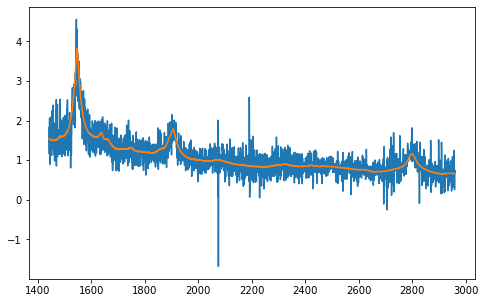

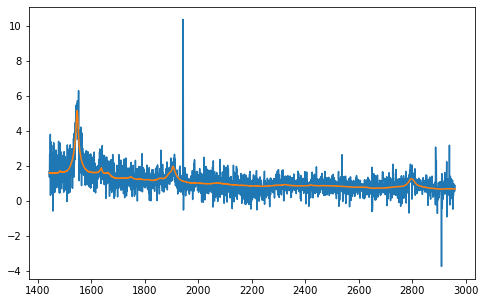

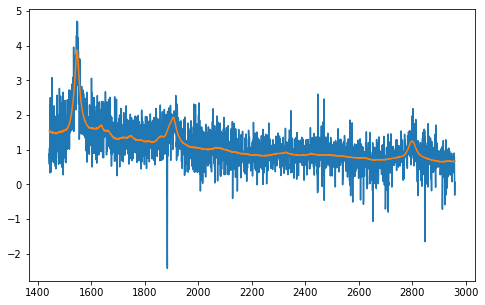

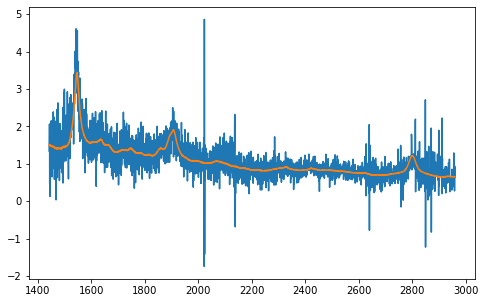

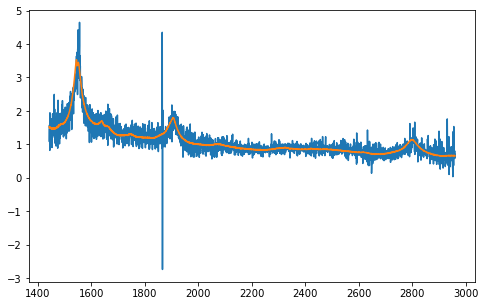

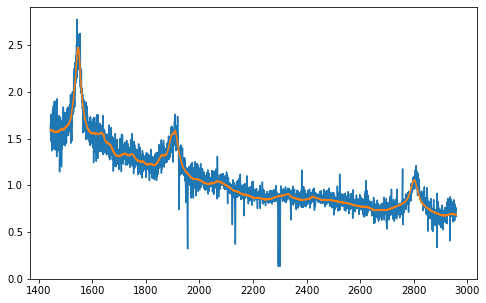

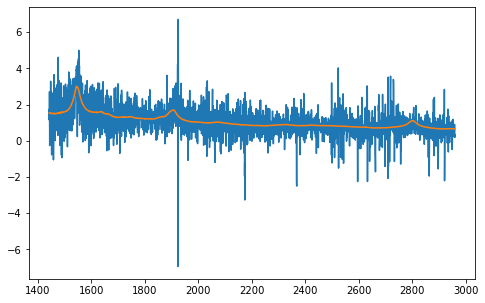

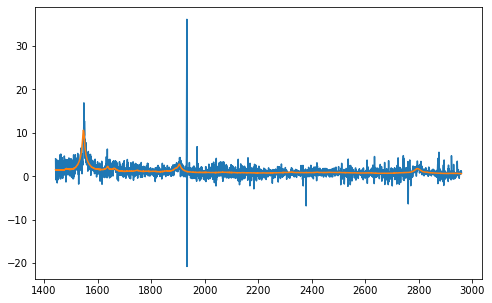

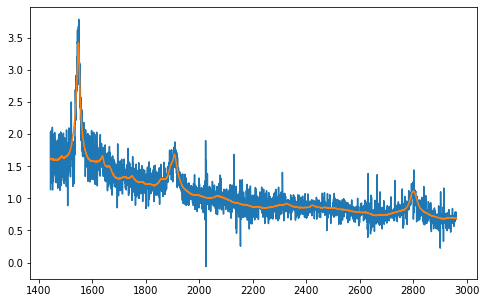

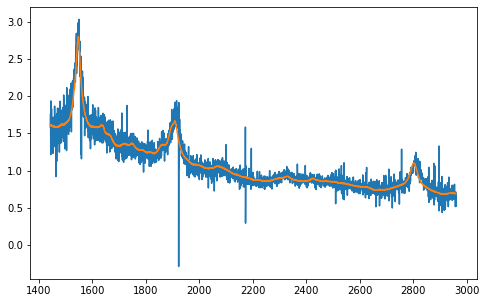

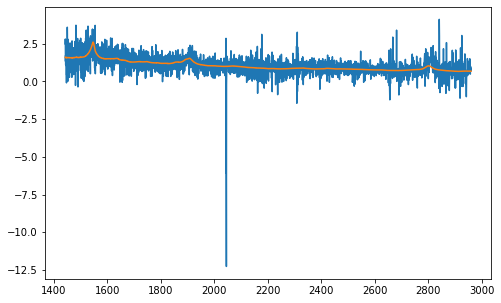

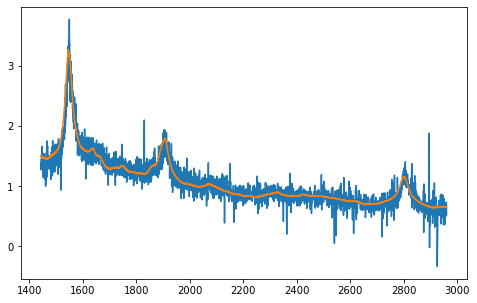

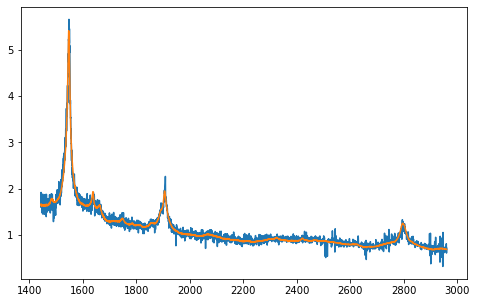

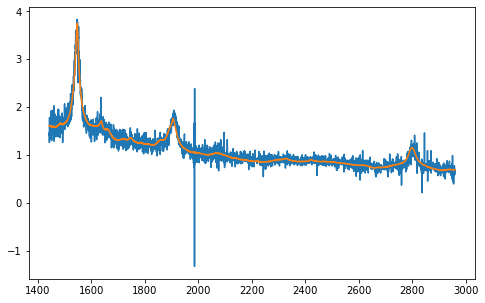

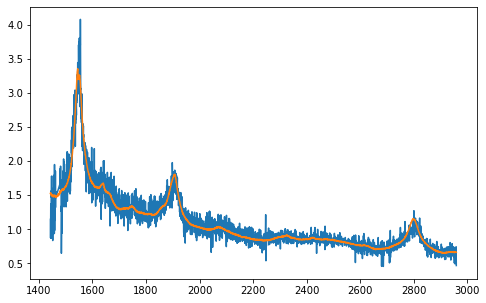

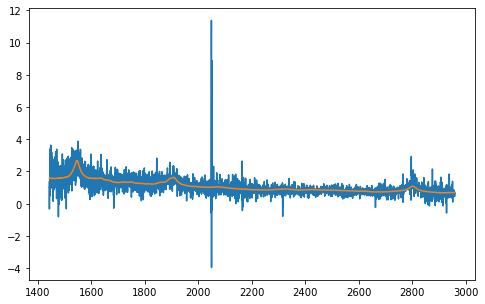

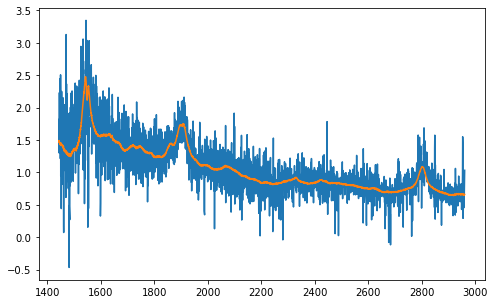

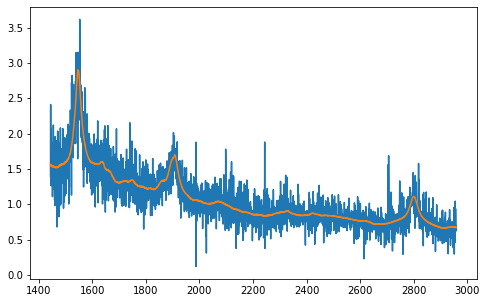

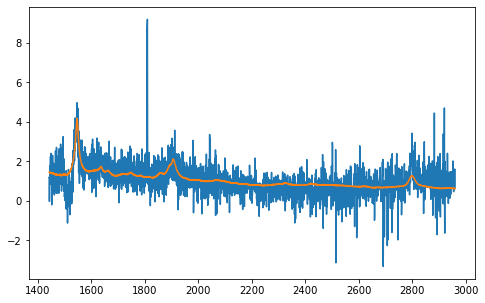

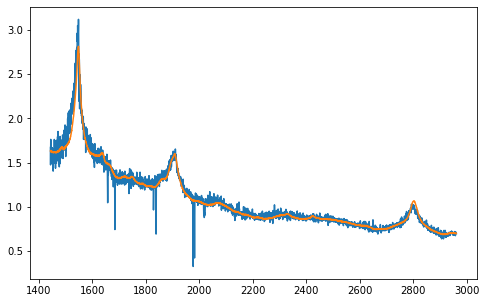

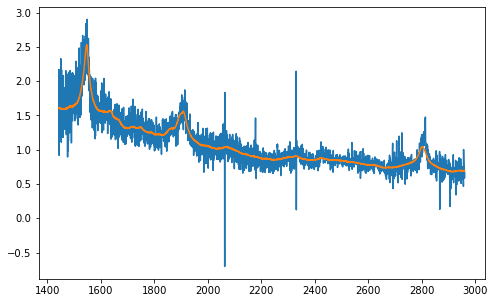

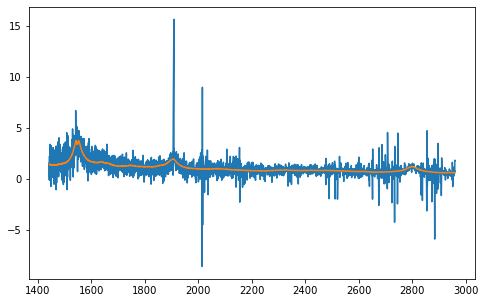

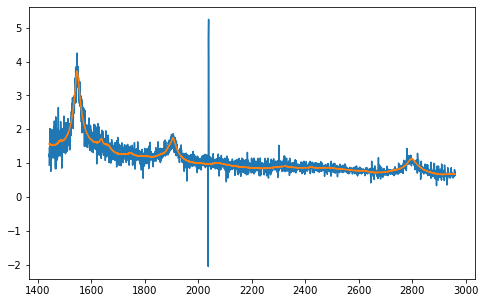

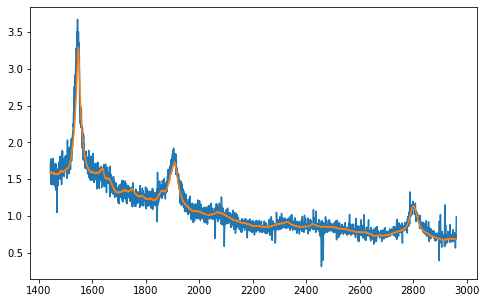

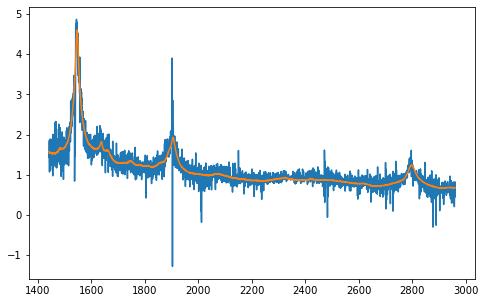

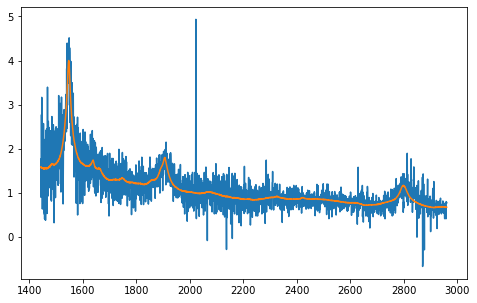

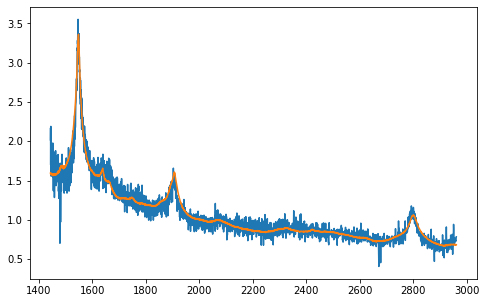

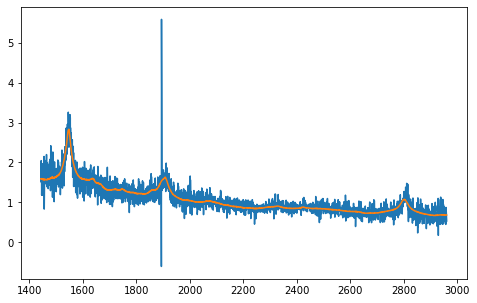

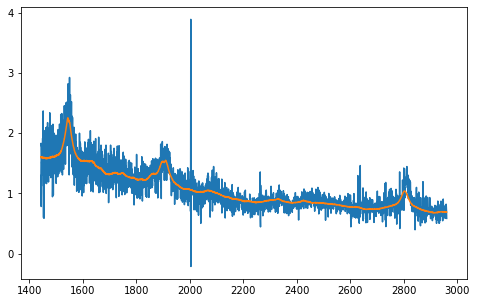

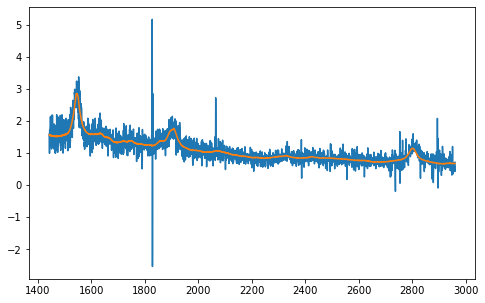

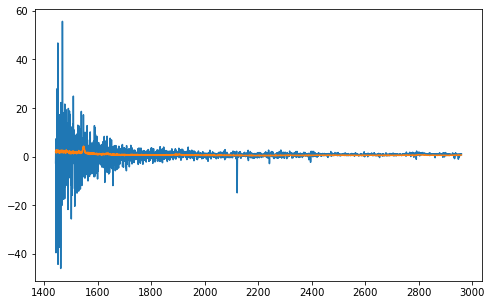

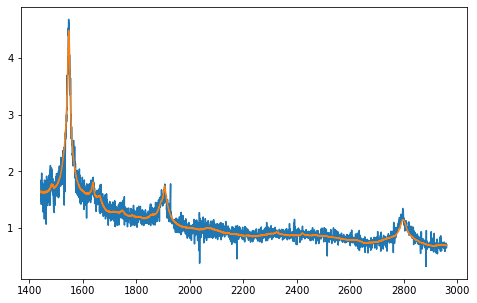

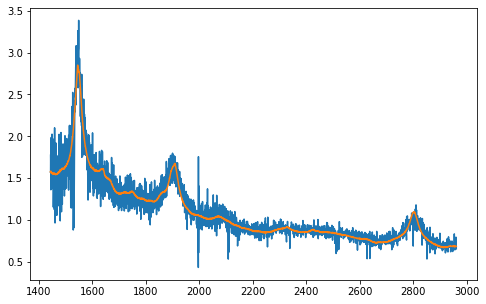

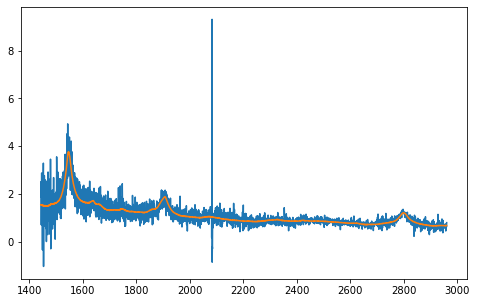

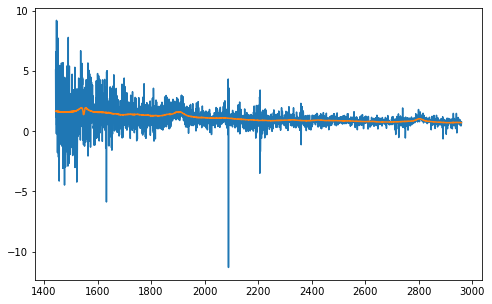

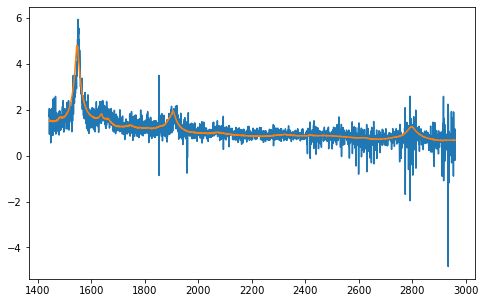

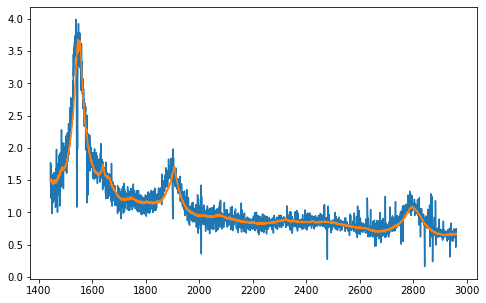

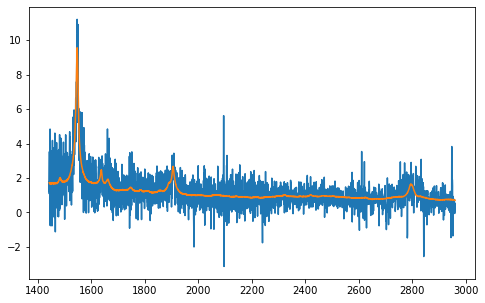

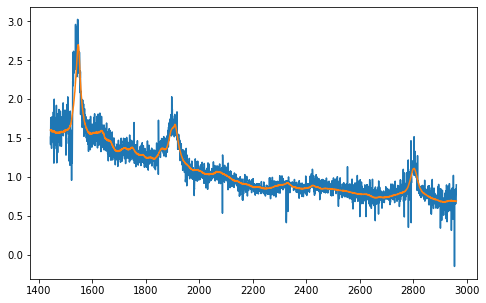

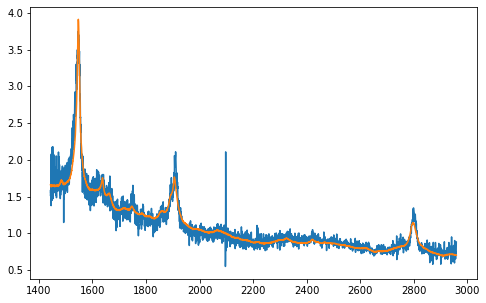

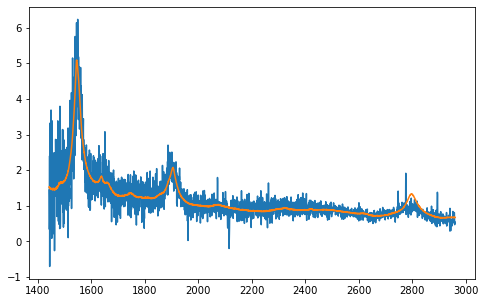

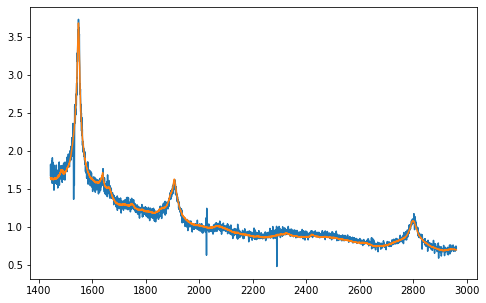

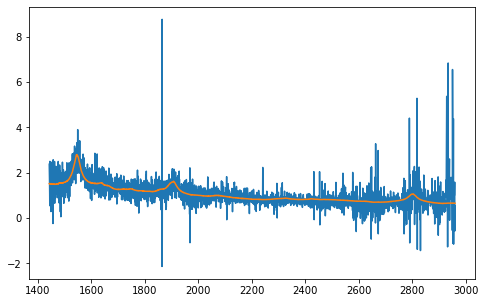

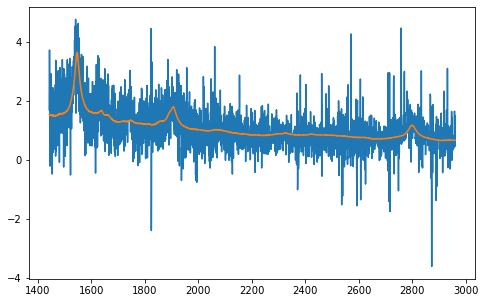

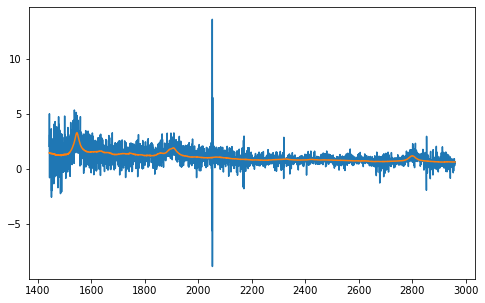

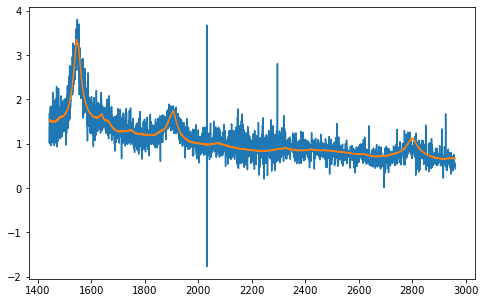

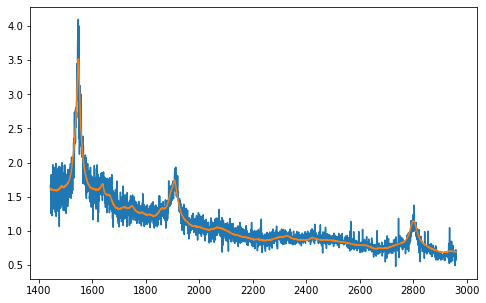

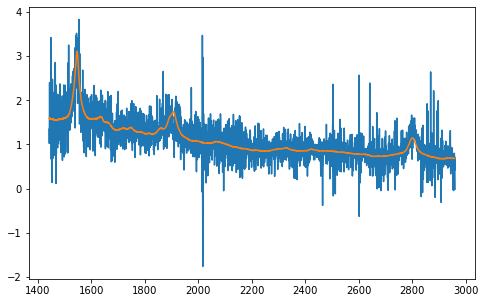

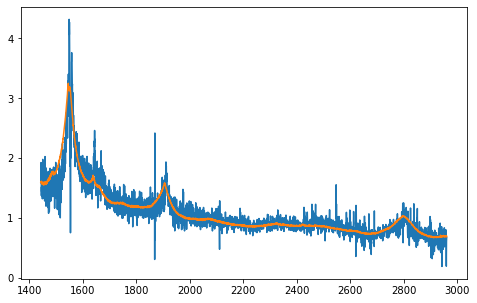

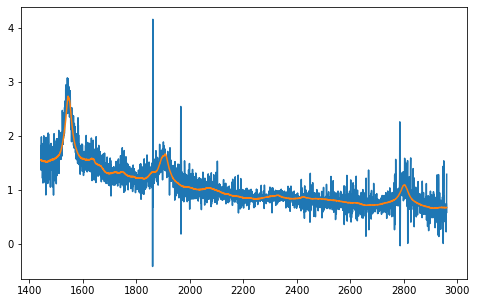

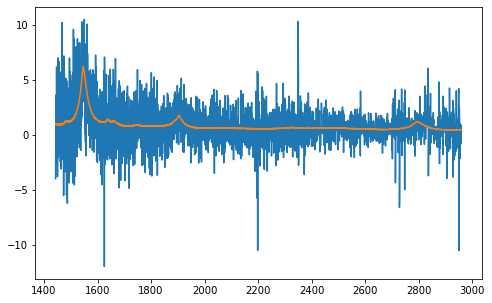

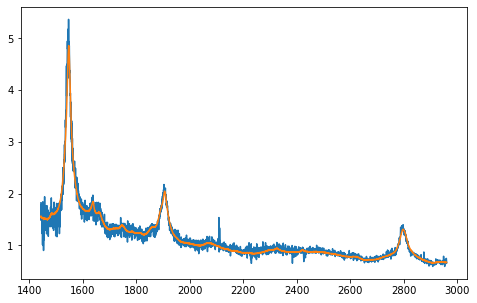

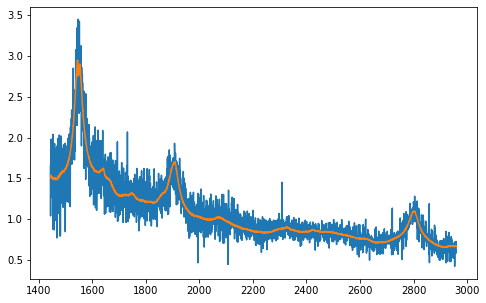

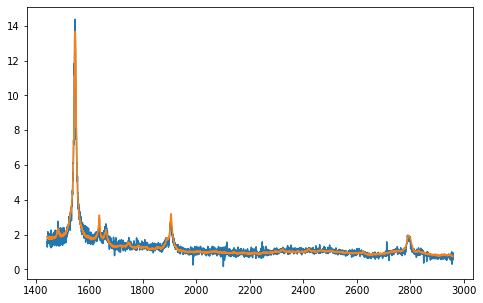

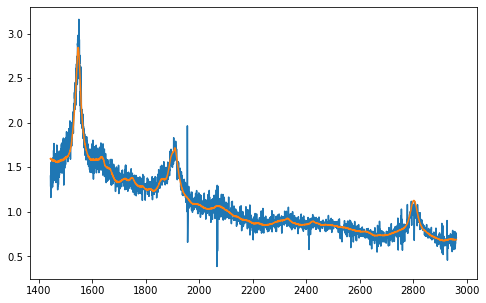

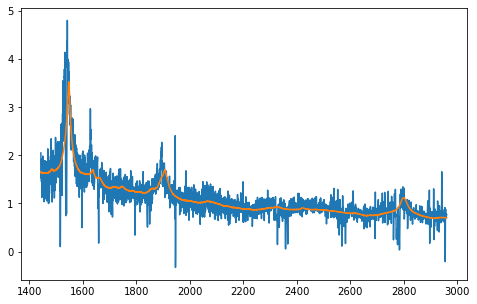

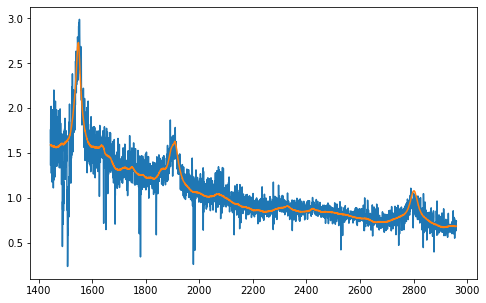

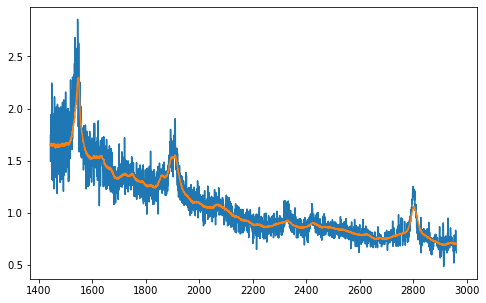

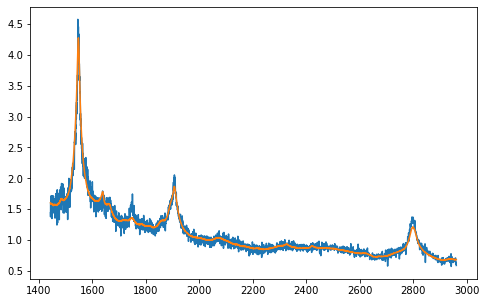

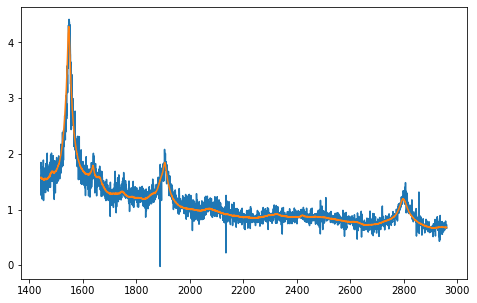

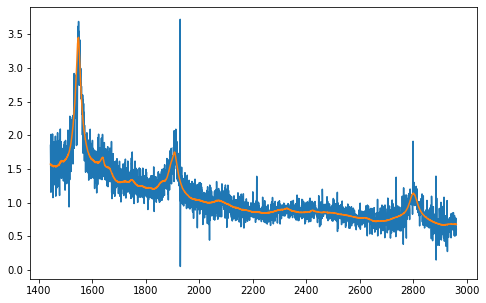

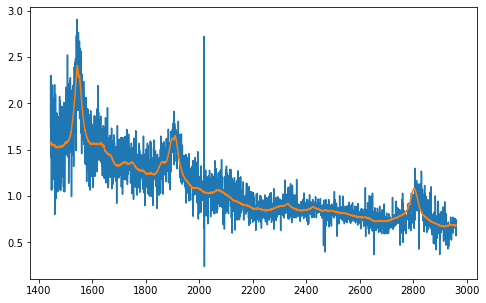

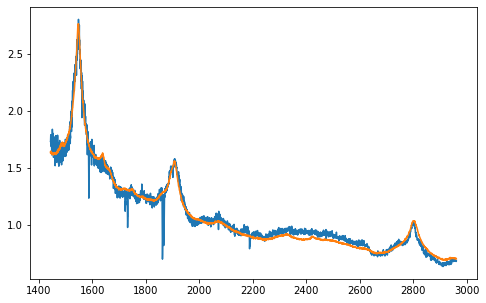

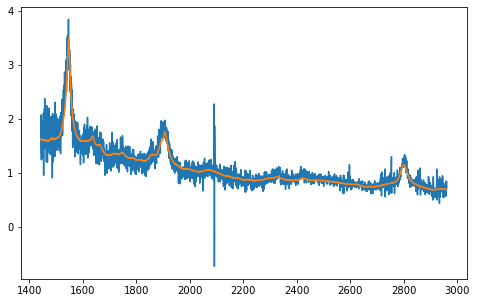

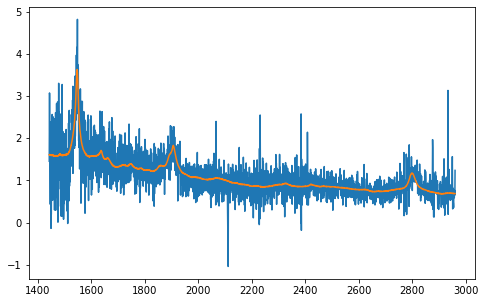

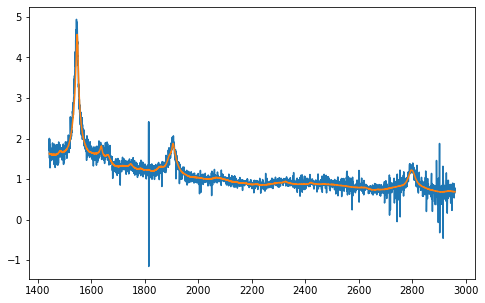

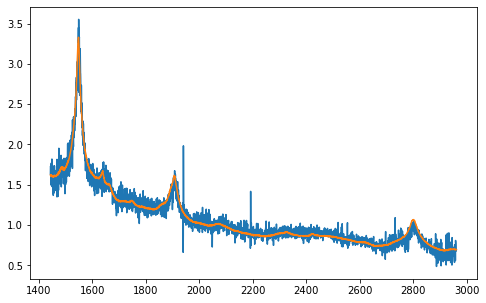

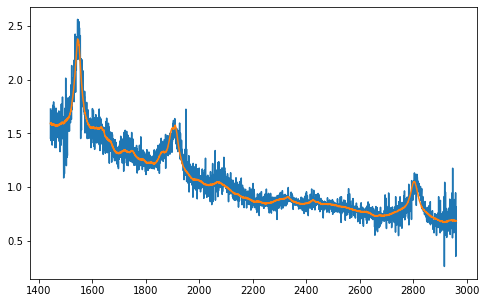

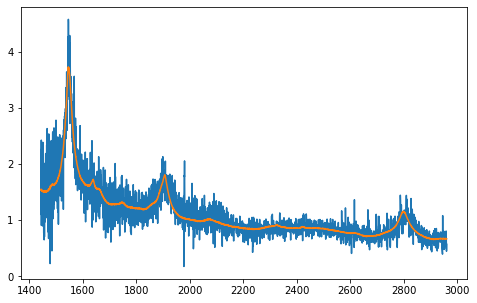

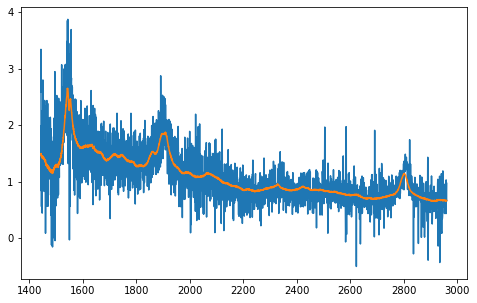

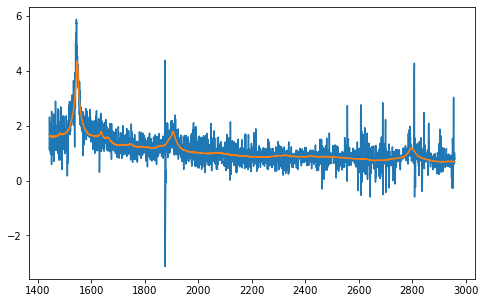

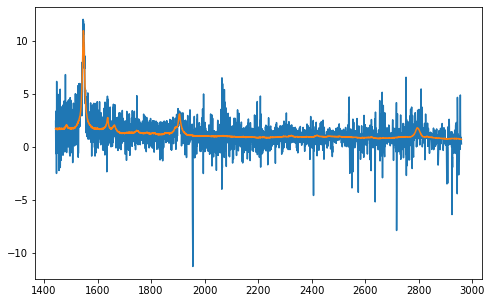

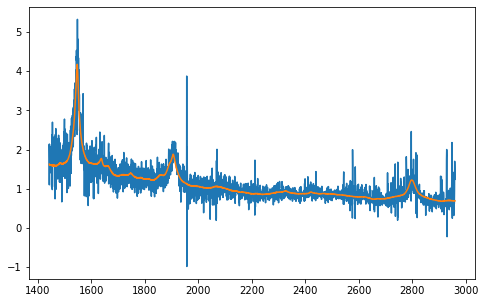

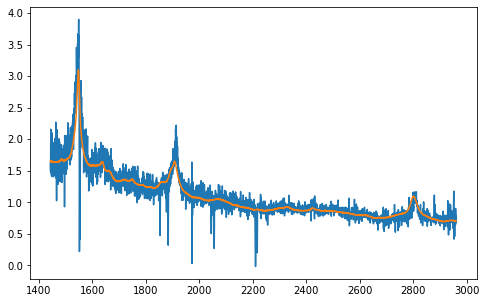

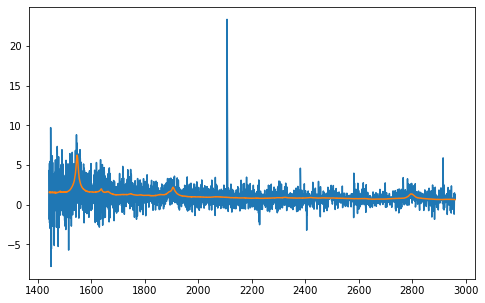

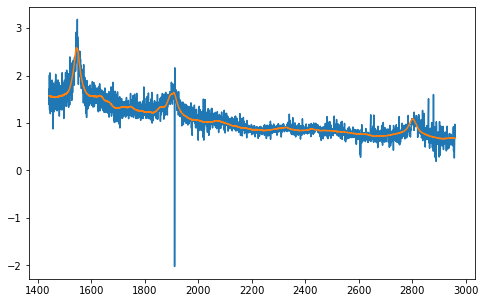

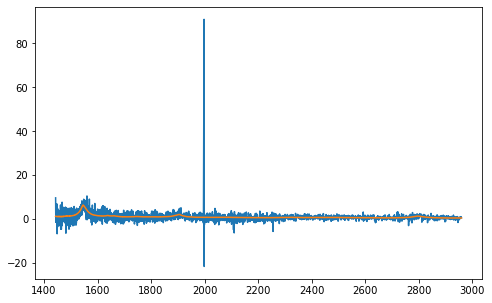

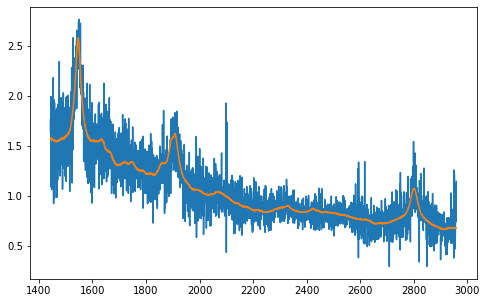

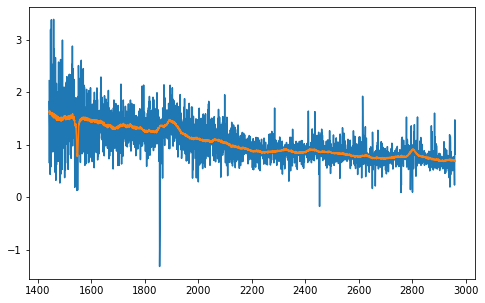

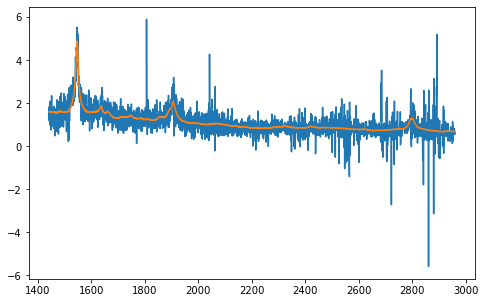

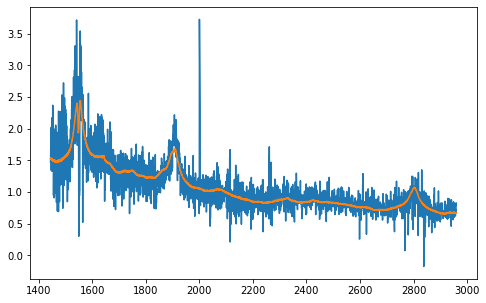

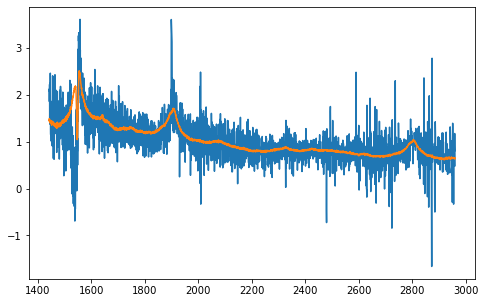

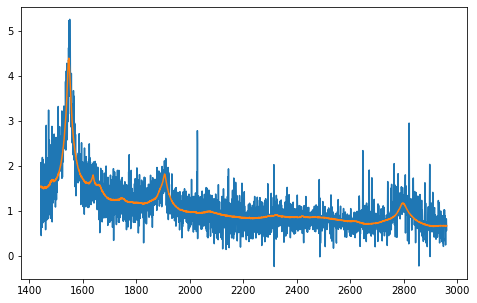

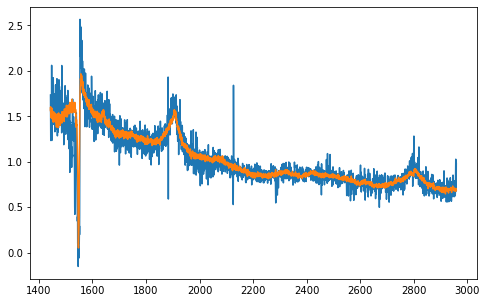

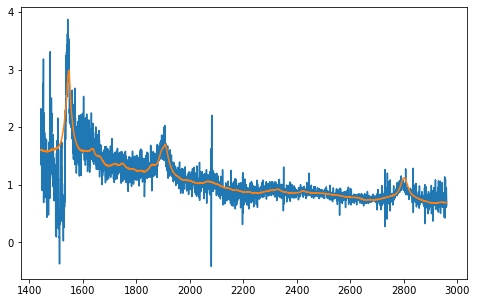

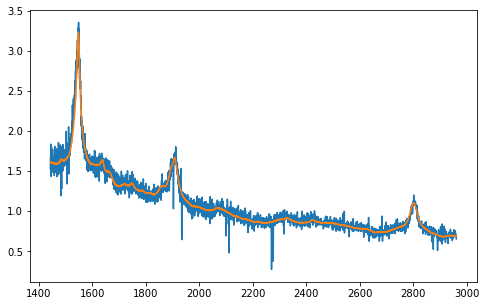

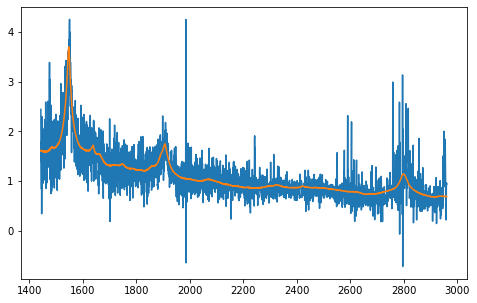

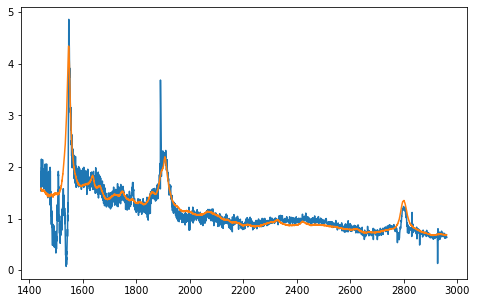

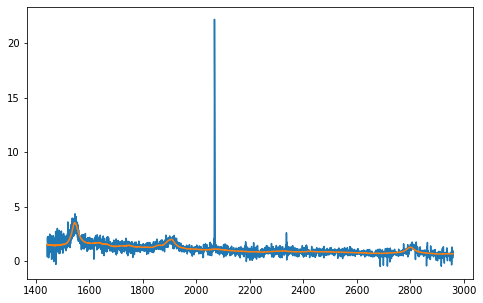

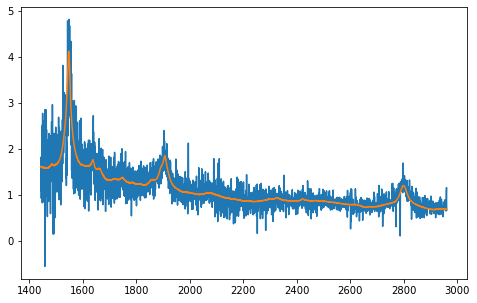

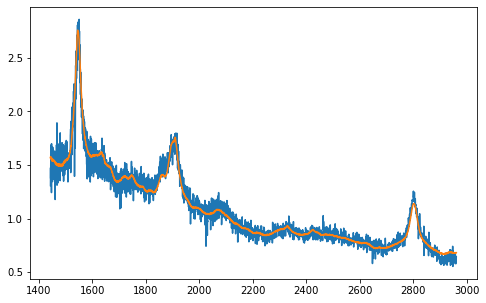

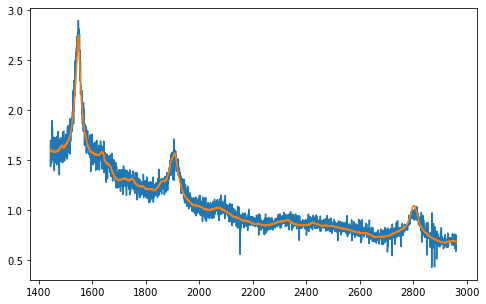

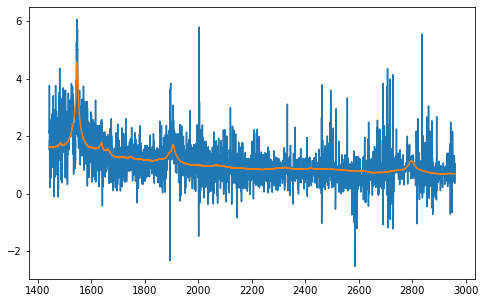

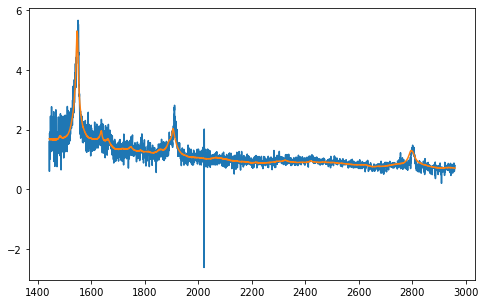

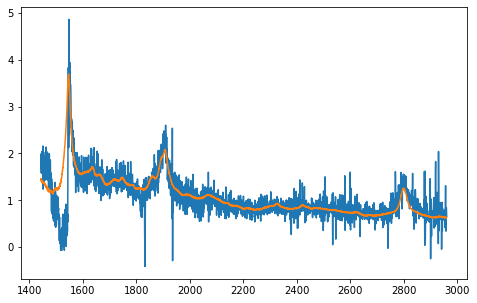

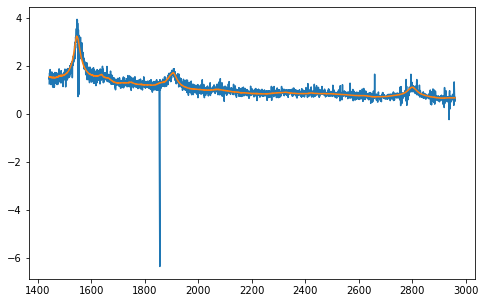

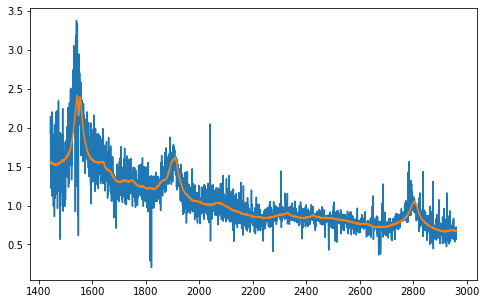

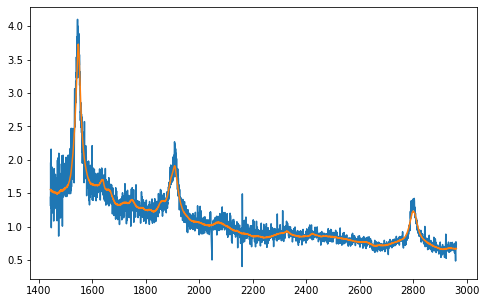

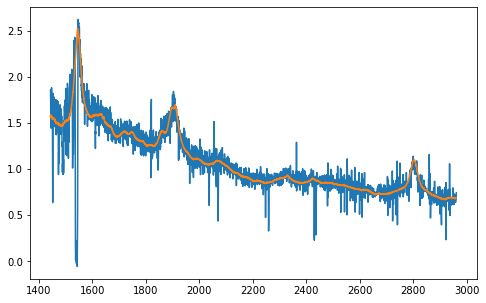

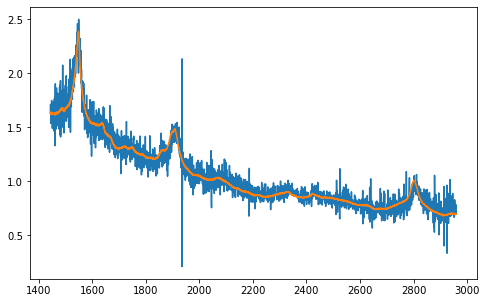

In [100]:
for i in range(n_spectra):
    #reconst = stacked_ae.predict(np.array([X_valid[i]]))
    fig = plt.figure(figsize=(8,5))
    plt.plot(wave[6000+i], X_test[i])
    plt.plot(wave[6000+i], reconst[i])
    plt.show()

Generally pretty good, but definitely weak in some areas.  Stronger emission lines (CIII] and MgII) it seems to struggle with; odd that it seems to sometimes get those spectra right though.  Maybe move to DR14 and get some more spectra now; hopefully more training data will help with some issues.

``Adam`` is definitely the optimizer to use.

In [101]:
X = np.vstack([X_train, X_valid, X_test])
X.shape

(91962, 3121)

In [102]:
#Compress the spectra down to 10 dimensions
X_compressed = stacked_encoder.predict(X)

In [103]:
X_compressed.shape

(91962, 6)

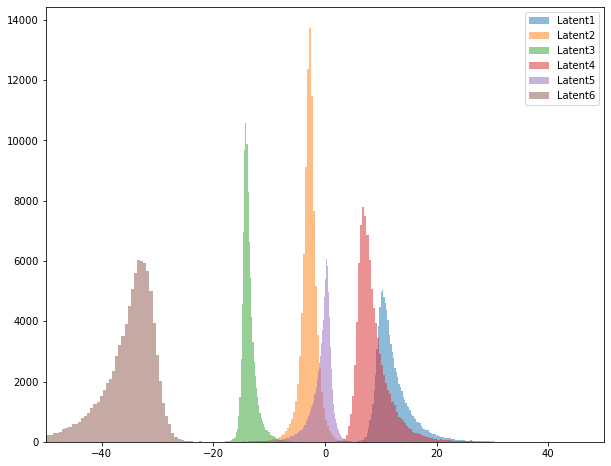

In [126]:
fig = plt.figure(figsize=(10,8))
for i in range(X_compressed.shape[1]):
    _ = plt.hist(X_compressed[:,i],bins='scott', alpha=0.5, label="Latent{}".format(i+1))
plt.legend(loc="best")
plt.xlim(-50, 50)
plt.show()

Note: The SeLU activation function leads to saturation at ~-1.75 for four of the latent parameters; use leaky ReLU to get nice distributions like above.

In [127]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2,learning_rate=150)
projTSNE2 = tsne.fit_transform(X_compressed)

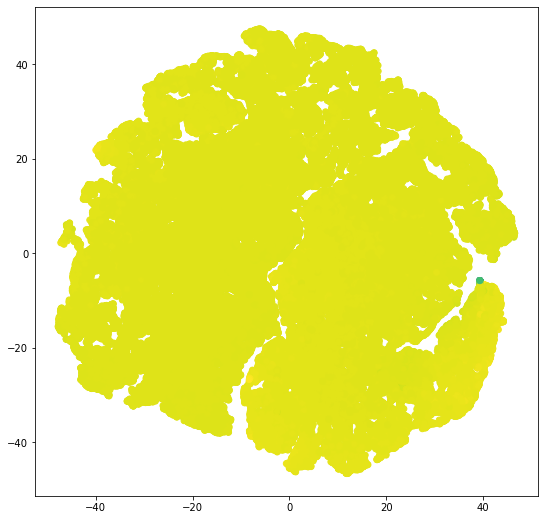

In [128]:
fig = plt.figure(figsize=(9,9))

plt.scatter(projTSNE2[:,0], projTSNE2[:,1], c=X_compressed[:,2])
plt.show()

Interesting... 

Now want to see what exactly each latent parameter represents.  Since we're dealing with 10 parameters, the space created by them is essentially a 10-dimensional hypersphere.  We can track the change caused by one parameter by holding the rest constant (at their median), and changing the value of the given latent parameter incrementally.  Then, after the increment, feed the latent parameters to the decoder and see what information it holds.

One strange (troublesome?) thing is that certain parameters change much more than others, but maybe I should just be running PCA to see which ones to throw out??  (That is, for visualization of just the parameters-- we still need them to reconstruct the spectrum because the decoder needs all)

In [129]:
X_compressed

array([[ 12.492883  ,  -3.9133573 , -13.882535  ,   9.127102  ,
         -0.47014242, -36.98317   ],
       [ 11.271163  ,  -2.491502  , -14.254286  ,   7.3736086 ,
         -0.60499007, -33.316597  ],
       [ 13.450294  ,  -4.644627  , -14.328725  ,   9.797005  ,
         -1.4467574 , -38.44181   ],
       ...,
       [ 13.411632  ,  -3.1313863 , -13.667415  ,   9.44772   ,
         -2.0859404 , -36.666965  ],
       [ 12.635264  ,  -3.865288  , -14.463427  ,   8.768254  ,
         -1.1842846 , -36.19248   ],
       [ 10.724488  ,  -3.2124104 , -14.409612  ,   7.2769537 ,
          0.34553382, -33.544548  ]], dtype=float32)

In [130]:
np.median(X_compressed, axis=0)

array([ 11.3355255 ,  -2.8218753 , -13.920256  ,   7.839617  ,
        -0.11914641, -34.204292  ], dtype=float32)

In [131]:
def blueshift(wave_half_flux):
    return ((1549.48 - wave_half_flux) / 1549.48) * 3e5

CIV EW = 39.36 Å, CIV Blueshift = 269.03 km/s


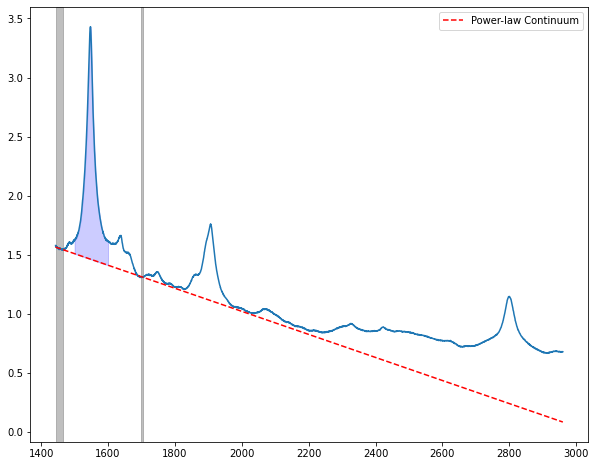

In [132]:
test = stacked_decoder.predict(np.array([np.median(X_compressed, axis=0)]))
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(wave[0], test[0])
#ax.plot([1549.48,1549.48], [10, 27], "--k", label="Laboratory Wavelength - CIV")
#plt.xscale("log")

#Find the blueshift
CIV = (wave[0]>1465)&(wave[0]<1650)
civ_peak = wave[0][CIV][test[0][CIV].argmax()]
#ax.plot([civ_peak,civ_peak], [10, 27], "--", label="Measured Wavelength - CIV")
#print(((1549.48-civ_peak)/1549.48)*3e5, "km/s")


#Fit continuum
cont1 = ((wave[0]>=1445)&(wave[0]<=1465))
cont2 = ((wave[0]>=1700)&(wave[0]<=1705))
ax.axvspan(1445, 1465, alpha=0.5, color='grey')
ax.axvspan(1700, 1705, alpha=0.5, color='grey')


m,b = np.polyfit(np.concatenate((wave[0][cont1], wave[0][cont2])), np.concatenate((test[0][cont1], test[0][cont2])), 1)
continuum = wave[0]*m + b
plt.plot(wave[0], continuum, "--r", label="Power-law Continuum")\

#Plot EW to compute
EW = ((wave[0]>=1500)&(wave[0]<=1600))
ax.fill_between(wave[0][EW], 
                continuum[EW],
                test[0][EW], color="blue", alpha=0.2)

#And compute the EW
CIV_EW = 0
ew_list = [0.]
for i in range(len(wave[0][EW])):
    try:
        CIV_EW += ( (test[0][EW][i] - continuum[i]) / continuum[i] ) * ( wave[0][EW][i+1] - wave[0][EW][i] )
    except IndexError:
        CIV_EW += ( (test[0][EW][i] - continuum[i]) / continuum[i] ) * ( wave[0][EW][i] - wave[0][EW][i-1] )
        
    ew_list.append(CIV_EW)
        
        
ind_half_flux = abs((CIV_EW / 2) - np.array(ew_list)).argmin()

print("CIV EW = %.2f Å, CIV Blueshift = %.2f km/s" % (CIV_EW, blueshift(wave[0][EW][ind_half_flux])))

plt.legend(loc="best")
plt.show()

In [133]:
def get_latent(X_comp, n, n_versions):
    #remove comments to plot - but this causes problems since noisy spectra are at extrema,
    #so just return spectra and choose which to plot
    
    #fig = plt.figure(figsize=(12,10))
    
    predictions = np.array([])
    
    #Set bounds to traverse when plotting differences
    low, high = max(np.min(X_comp[:,n]), -50), min(np.max(X_comp[:,n]), 20)
    
    #get the median for all other values
    median = np.median(X_comp, axis=0)
    #median_other = np.delete(X_comp, n)
    
    #loop through min-->max and get corresponding spectra
    for i in np.linspace(low, high, n_versions): #maybe sample from logspace here instead?
        latent_params = median.copy()
        latent_params[n] = i
        predict = stacked_decoder.predict(np.array([latent_params]))
        
        if len(predictions) > 0:
            predictions = np.vstack([predictions, predict])
        else:
            predictions = np.append(predictions, predict)
        
        #plt.plot(wave[0], predict[0], alpha=0.6)
        
        
    #plt.show()
    
    return predictions

In [134]:
n_diff = 12
prediction = np.array([[]])

predict1 = get_latent(X_compressed, 0, n_diff)
predict2 = get_latent(X_compressed, 1, n_diff)
predict3 = get_latent(X_compressed, 2, n_diff)
predict4 = get_latent(X_compressed, 3, n_diff)
predict5 = get_latent(X_compressed, 4, n_diff)
predict6 = get_latent(X_compressed, 5, n_diff)
#predict7 = get_latent(X_compressed, 6, n_diff)
#predict8 = get_latent(X_compressed, 7, n_diff)
#predict9 = get_latent(X_compressed, 8, n_diff)
#predict10= get_latent(X_compressed, 9, n_diff)

In [135]:
predict1[0]

array([-0.29205757,  0.68080294,  0.19745442, ...,  0.71909523,
       -0.17840959,  0.3643679 ])

In [136]:
def plot_latent(prediction, omit=0, reverse=True):
    fig = plt.figure(figsize=(12,10))
    if reverse:
        for i in range(prediction.shape[0]-1-omit, -1, -1):
            plt.plot(wave[0], prediction[i], label="Inc{}".format(i+1))
    else:
        for i in range(prediction.shape[0]-omit):
            plt.plot(wave[0], prediction[i], label="Inc{}".format(i+1))
    plt.legend(loc="best")
    plt.show()

#### Param1

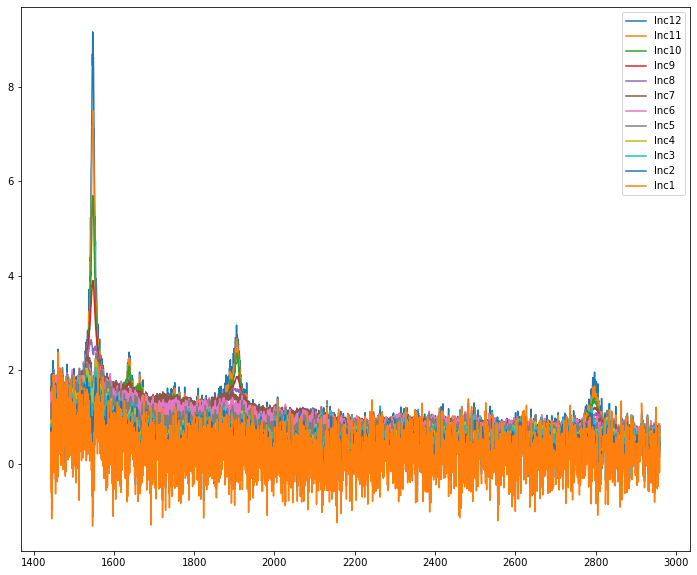

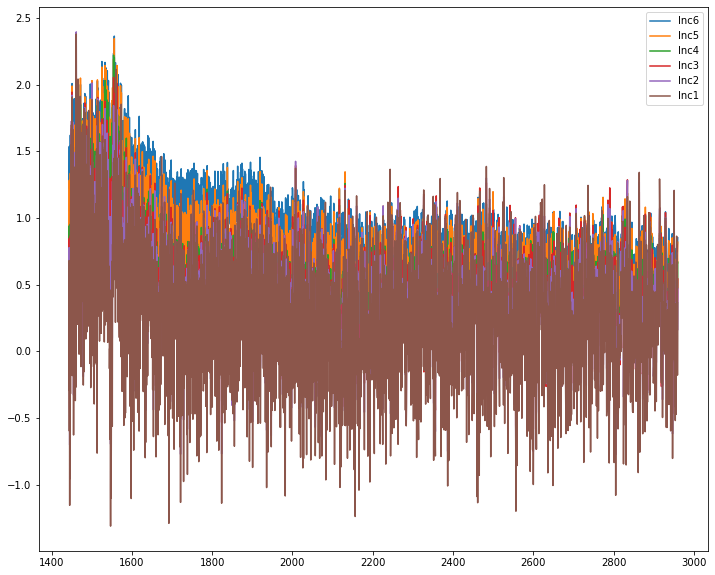

In [137]:
plot_latent(predict1, reverse=True)
plot_latent(predict1, omit=6,  reverse=True)

#### Param2

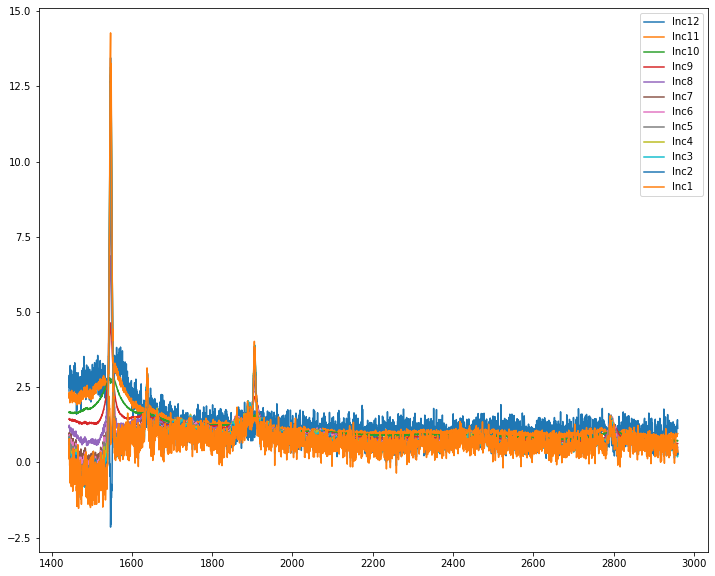

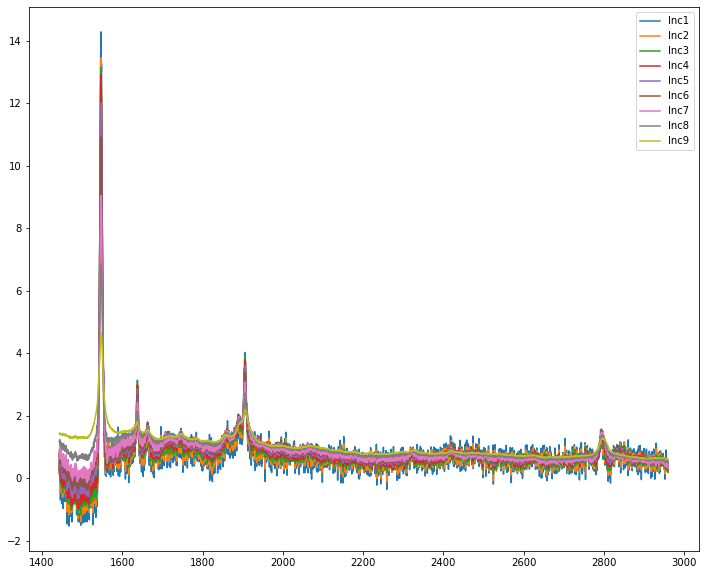

In [138]:
plot_latent(predict2)
plot_latent(predict2, omit=3, reverse=False)

#### Param3

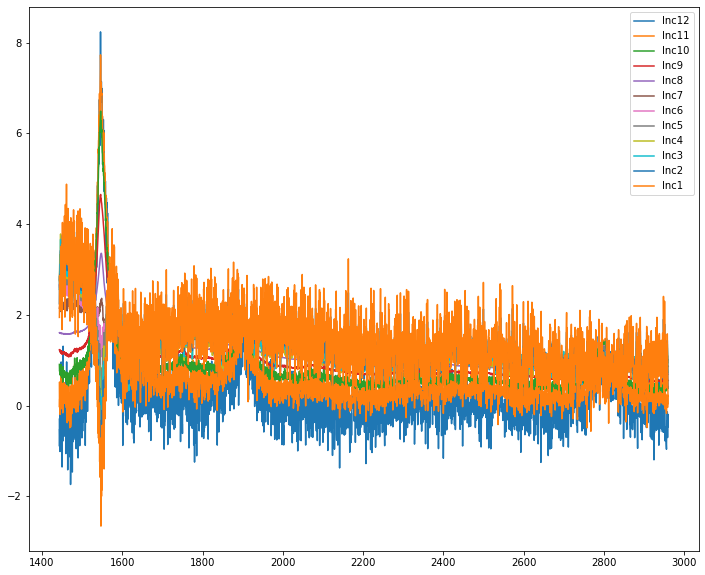

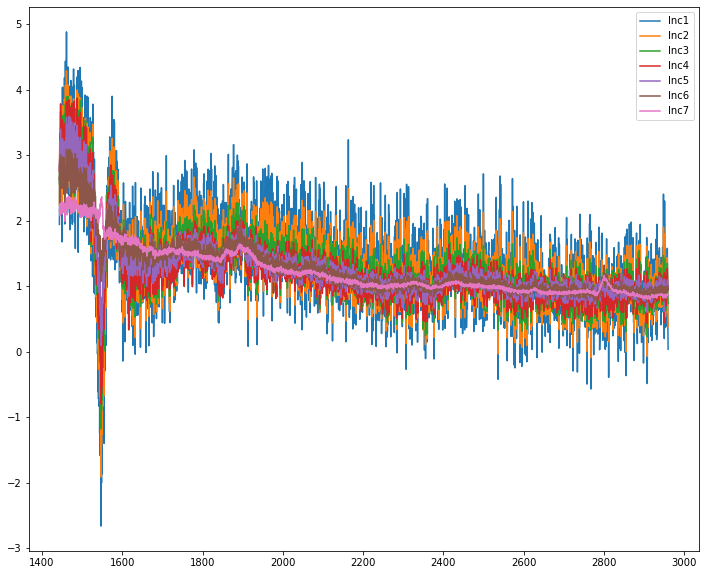

In [148]:
plot_latent(predict3, reverse=True)
plot_latent(predict3, omit=5, reverse=False)


#### Param4

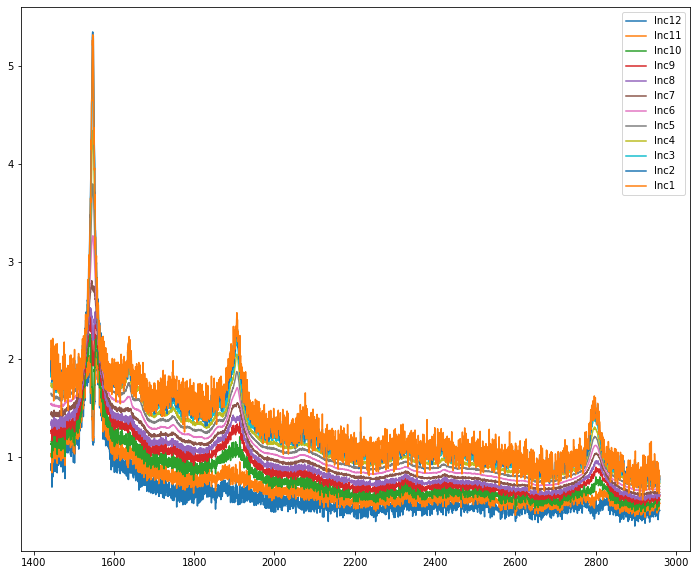

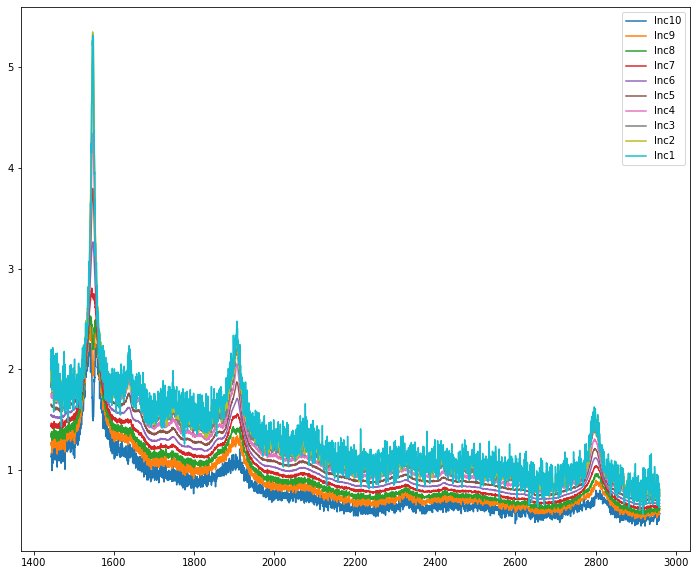

In [149]:
plot_latent(predict4, reverse=True)
plot_latent(predict4, omit=2, reverse=True)

Higher vals tend towards CIV BAL, noisier spectrum

#### Param5

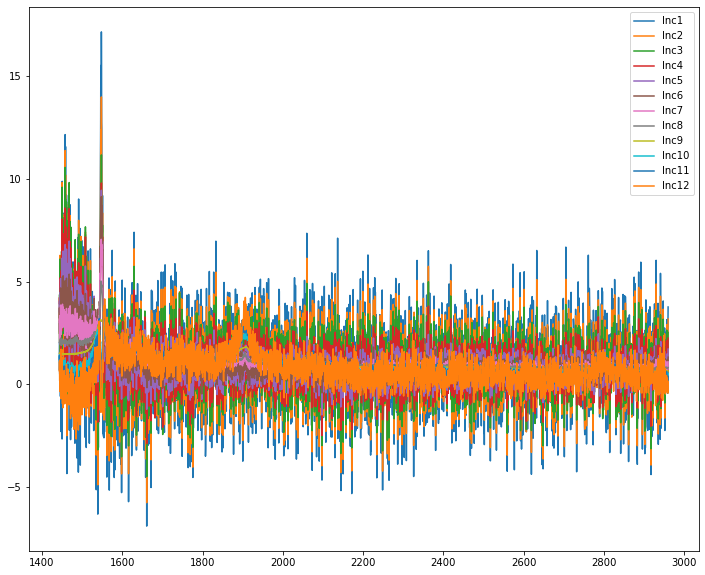

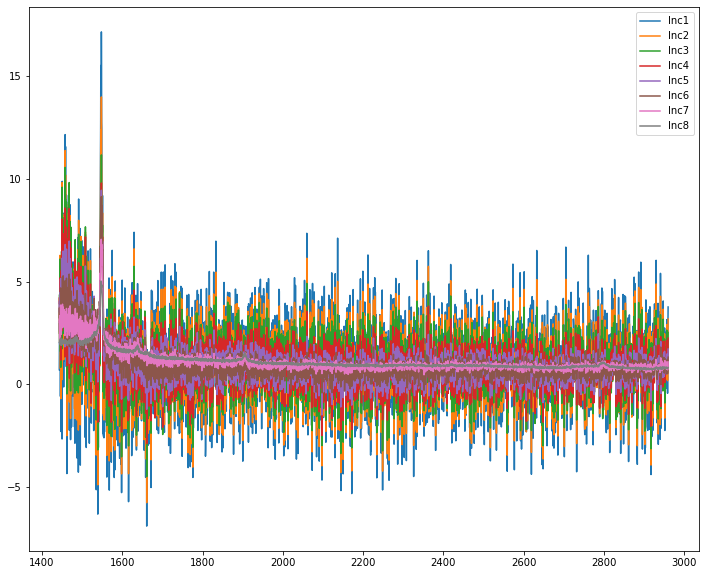

In [152]:
plot_latent(predict5, reverse=False)
plot_latent(predict5, omit=4, reverse=False)

#### Param6

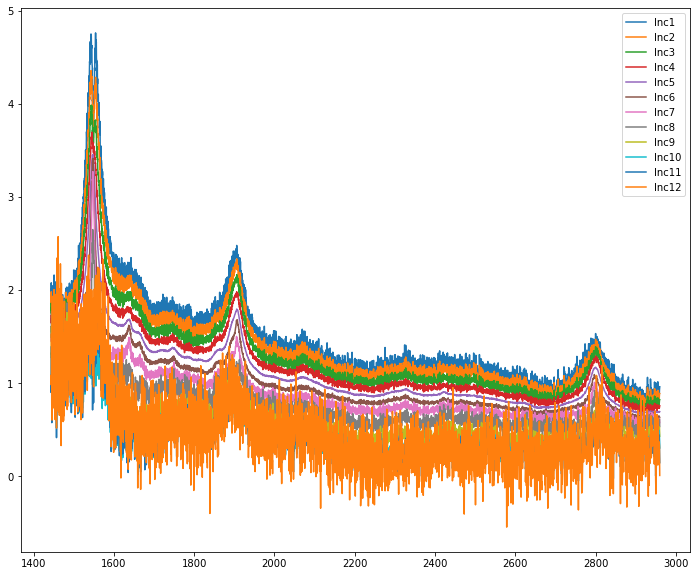

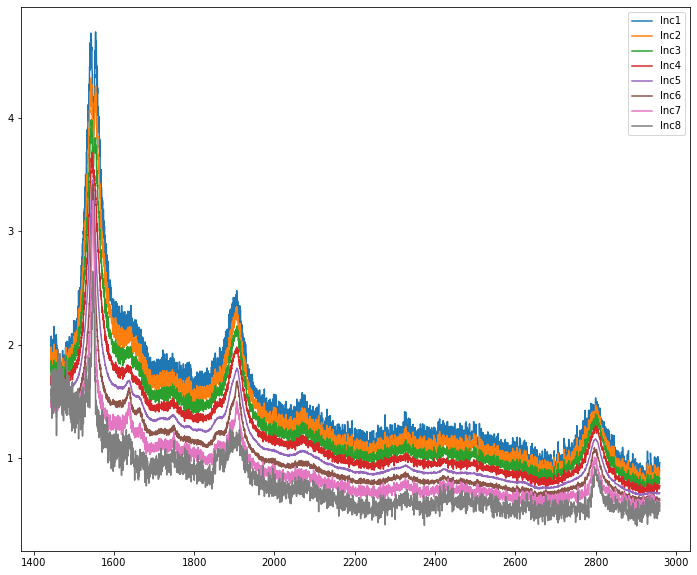

In [153]:
plot_latent(predict6, reverse=False)
plot_latent(predict6, omit=4, reverse=False)

In [143]:
def plotTSNE(colorcode, mask, lab=""):
    fig = plt.figure(figsize=(9,9))
    plt.scatter(projTSNE2[:,0], projTSNE2[:,1], c=colorcode, vmin=np.percentile(colorcode, 15), 
                vmax=np.percentile(colorcode, 85), label=lab)
    plt.colorbar()
    plt.legend(loc="best")
    plt.show()

In [144]:
dat.head()

Unnamed: 0              SDSS_NAME        RA        DEC   THING_ID  PLATE  \
0          10  b'000001.56+203011.5'  0.006523  20.503197  290594773   7596   
1          19  b'000002.15+151516.6'  0.008980  15.254639  246765254   6172   
2          20  b'000002.19-021947.2'  0.009139  -2.329783   59825899   7850   
3          26  b'000002.97+225645.9'  0.012415  22.946096  311303506   7665   
4          28  b'000003.18+050822.3'  0.013254   5.139552  155964498   8740   

     MJD  FIBERID  SPECTRO         Z  ...         JFLUX     JFLUX_ERR  \
0  56945      821  b'BOSS'  2.083215  ...  0.000000e+00  0.000000e+00   
1  56269      394  b'BOSS'  1.710000  ...  2.910325e-31  4.694344e-32   
2  56956      339  b'BOSS'  1.966623  ...  0.000000e+00  0.000000e+00   
3  57328      452  b'BOSS'  1.759105  ...  0.000000e+00  0.000000e+00   
4  57367      340  b'BOSS'  1.801677  ...  1.431263e-31  4.114480e-32   

          HFLUX     HFLUX_ERR         KFLUX     KFLUX_ERR  FIRST_MATCHED  \
0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00             -1   
1  1.572201e-31  5.927228e-32  1.538285e-31  6.478741e-32             -1   
2  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00              0   
3  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00             -1   
4  8.260369e-32  4.348945e-32  2.371781e-31  5.186590e-32              0   

   FIRST_FLUX  FIRST_SNR  SDSS2FIRST_SEP  
0        -1.0       -1.0            -1.0  
1        -1.0       -1.0            -1.0  
2        -1.0       -1.0            -1.0  
3        -1.0       -1.0            -1.0  
4        -1.0       -1.0            -1.0  

[5 rows x 97 columns]

In [155]:
dat.columns

Index(['Unnamed: 0', 'SDSS_NAME', 'RA', 'DEC', 'THING_ID', 'PLATE', 'MJD',
       'FIBERID', 'SPECTRO', 'Z', 'Z_ERR', 'SOURCE_Z', 'Z_VI', 'Z_PIPE',
       'Z_PIPE_ERR', 'ZWARNING', 'Z_PCA', 'Z_PCA_ER', 'Z_MGII', 'BOSS_TARGET1',
       'ANCILLARY_TARGET1', 'ANCILLARY_TARGET2', 'EBOSS_TARGET0',
       'EBOSS_TARGET1', 'EBOSS_TARGET2', 'N_SPEC_SDSS', 'N_SPEC_BOSS',
       'N_SPEC', 'BI_CIV', 'ERR_BI_CIV', 'RUN_NUMBER', 'RERUN_NUMBER',
       'COL_NUMBER', 'FIELD_NUMBER', 'OBJ_ID', 'MI', 'RASS_COUNTS',
       'RASS_COUNTS_SNR', 'SDSS2ROSAT_SEP', 'FLUX_0.2_2.0keV',
       'FLUX_0.2_2.0keV_ERR', 'FLUX_2.0_12.0keV', 'FLUX_2.0_12.0keV_ERR',
       'FLUX_0.2_12.0keV', 'FLUX_0.2_12.0keV_ERR', 'LUM_0.2_12.0keV',
       'SDSS2XMM_SEP', 'GALEX_MATCHED', 'FUV', 'FUV_IVAR', 'NUV', 'NUV_IVAR',
       'JMAG', 'ERR_JMAG', 'JSNR', 'JRDFLAG', 'HMAG', 'ERR_HMAG', 'HSNR',
       'HRDFLAG', 'KMAG', 'ERR_KMAG', 'KSNR', 'KRDFLAG', 'SDSS2MASS_SEP',
       'W1MAG', 'ERR_W1MAG', 'W1SNR', 'W1CHI2', 'W2MAG', 'ERR_W

In [145]:
len(found)

91970

In [ ]:
np.percentile(dat[["LOGLBOL_1"]].values.flatten(), 15)

In [ ]:
plotTSNE(dat[["LOGLBOL_1"]].values.flatten()[found.astype(int)], found.astype(int), "LOGLBOL")
plotTSNE(dat[["EW_CIV_1"]].values.flatten()[found.astype(int)], found.astype(int), "EW_CIV")
plotTSNE(dat[["VOFF_CIV_PEAK_1"]].values.flatten()[found.astype(int)], found.astype(int), "Blueshift")
plotTSNE(dat[["LOGEDD_RATIO_1"]].values.flatten()[found.astype(int)], found.astype(int), "Log Edd Ratio")
plotTSNE(dat[["E_BV_1"]].values.flatten()[found.astype(int)], found.astype(int), "E(B--V)")
plotTSNE(dat[["R_6CM_2500A_1"]].values.flatten()[found.astype(int)], found.astype(int), "R - radio")
plotTSNE(dat[["BAL_FLAG_1"]].values.flatten()[found.astype(int)], found.astype(int), "BAL?")
plotTSNE(dat[["FIRST_FR_TYPE_1"]].values.flatten()[found.astype(int)], found.astype(int), "FR Type")

Maybe objects with high Lbol like to hang in the upper right??

Do PCA and throw out some lower-significance components.  Then t-SNE again.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.pipeline      import Pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()), #normalizing data
                ('reducer', PCA())])           #dimensionality reduction

pc = pipe.fit_transform(X_compressed)          #data goes here for processing

#Extracting useful metrics
var = pipe.steps[1][1].explained_variance_ratio_
var_sum = pipe.steps[1][1].explained_variance_ratio_.cumsum()

In [ ]:
fig = plt.figure(figsize=(9,9))

plt.plot(var)
plt.plot(var,'r*')
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance')
plt.grid(True)
plt.show()

Did PCA order the features for me??  Maybe don't want this.

In [157]:
pc.shape

(91962, 6)

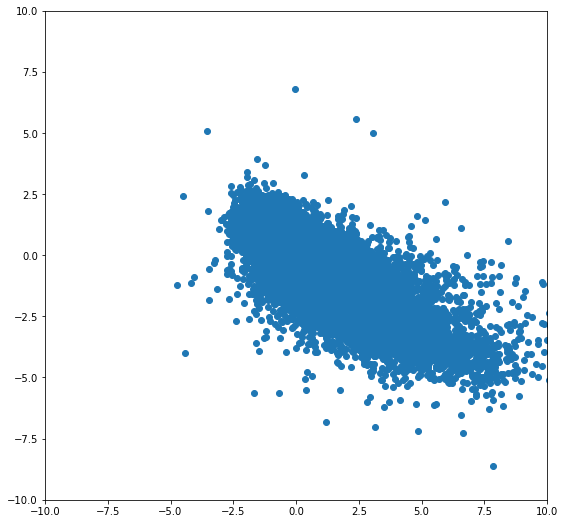

In [159]:
fig = plt.figure(figsize=(9,9))
#plt.scatter(X_compressed[:,0], X_compressed[:,1])
plt.scatter(pc[:,0], pc[:,1])
plt.ylim(-10,10)
plt.xlim(-10,10)
plt.show()

In [160]:
pd.DataFrame(X_compressed)

0         1          2          3         4          5
0      12.492883 -3.913357 -13.882535   9.127102 -0.470142 -36.983170
1      11.271163 -2.491502 -14.254286   7.373609 -0.604990 -33.316597
2      13.450294 -4.644627 -14.328725   9.797005 -1.446757 -38.441811
3      12.848826 -1.967181 -12.792964   9.355849 -0.629202 -36.531136
4      12.141754 -2.059553 -13.495050   8.480885 -0.369478 -35.090137
...          ...       ...        ...        ...       ...        ...
91957  17.687237 -0.733118 -10.652051  13.779227 -3.586381 -43.343716
91958  11.179973 -3.242932 -14.235352   7.681797  0.037015 -34.274689
91959  13.411632 -3.131386 -13.667415   9.447720 -2.085940 -36.666965
91960  12.635264 -3.865288 -14.463427   8.768254 -1.184285 -36.192478
91961  10.724488 -3.212410 -14.409612   7.276954  0.345534 -33.544548

[91962 rows x 6 columns]

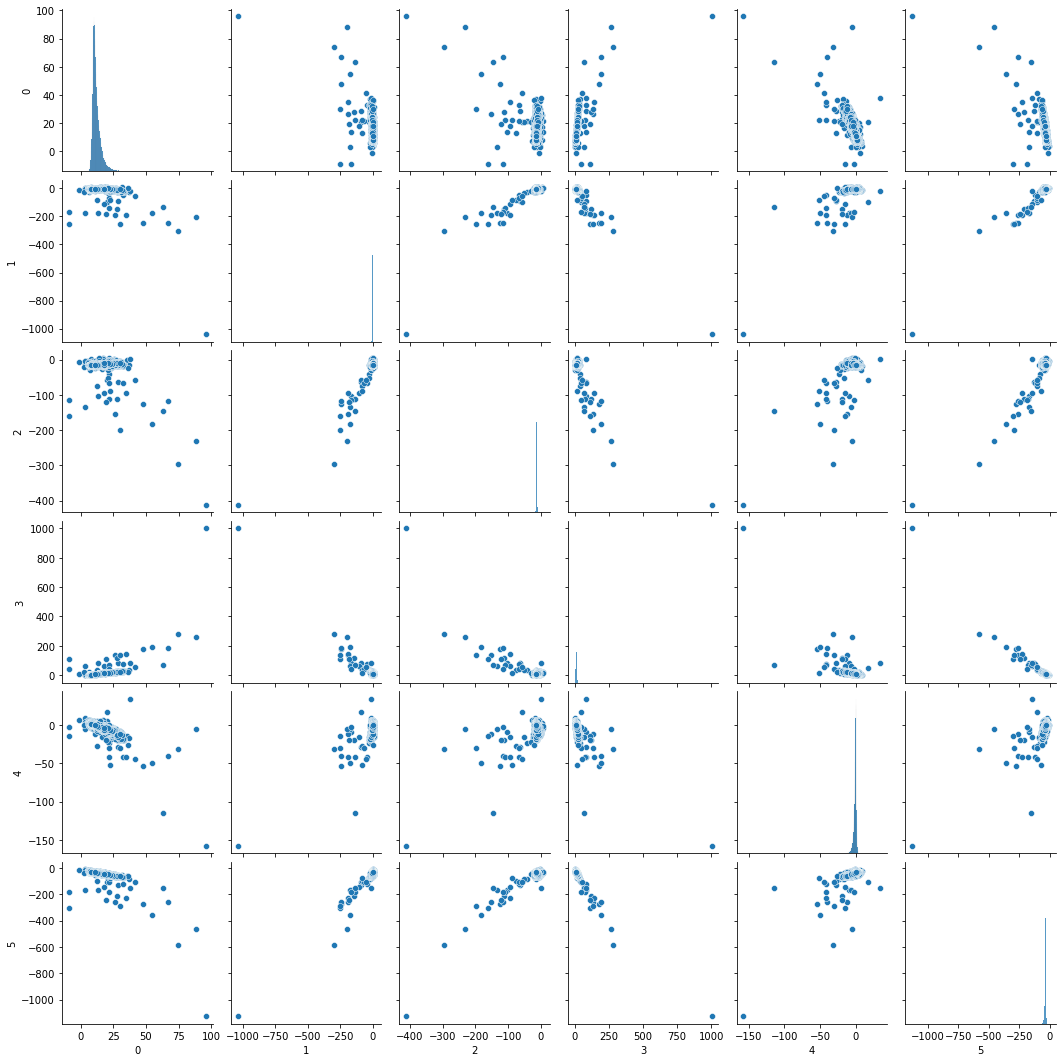

In [125]:
import seaborn

df = pd.DataFrame(X_compressed)

seaborn.pairplot(df)

---

Compute CIV EW and blueshift

In [464]:
X

array([[33.21803  , 33.921223 , 30.724604 , ..., 14.846318 , 13.317695 ,
        14.151351 ],
       [19.874874 , 20.790903 , 20.043615 , ...,  6.335633 ,  6.9407854,
         5.820573 ],
       [22.482862 , 23.138777 , 27.171658 , ..., 15.81914  , 15.413137 ,
        15.096482 ],
       ...,
       [14.459191 , 14.279158 , 14.267829 , ...,  7.5751047,  6.3564477,
         6.341022 ],
       [ 3.3154058,  6.9089637, 10.638741 , ...,  4.696215 ,  3.627235 ,
         6.040976 ],
       [ 7.4278784,  9.064822 ,  7.5617237, ...,  3.4098907,  4.9049726,
         3.3274734]], dtype=float32)

In [164]:
def get_CIV(wave, flux, reconstruction, name):
    #Going to save plots, but not show with magic above
    """
    fig, ax = plt.subplots(figsize=(10,8))
    ax.plot(wave, flux)
    ax.plot(wave, reconstruction, label="Autoencoder Reconstruction")
    ax.plot([1549.48,1549.48], [0.2*max(reconstruction), max(reconstruction)+2], "--k", label="Laboratory Wavelength - CIV")
    """
    
    #Fit continuum
    cont1 = ((wave>=1445)&(wave<=1465))
    cont2 = ((wave>=1700)&(wave<=1705))
    ax.axvspan(1445, 1465, alpha=0.5, color='grey')
    ax.axvspan(1700, 1705, alpha=0.5, color='grey')

    m,b = np.polyfit(np.concatenate((wave[cont1], wave[cont2])), np.concatenate((reconstruction[cont1], reconstruction[cont2])), 1)
    continuum = wave*m + b
    ax.plot(wave, continuum, "-r", label="Power-law Continuum")\

    
    #Plot EW region under reconstruction
    EW = ((wave>=1500)&(wave<=1600))
    #ax.fill_between(wave[EW], continuum[EW], reconstruction[EW], color="blue", alpha=0.2)

    #And compute the EW
    CIV_EW = 0
    ew_list = [0.]
    for i in range(len(wave[EW])):
        try:
            CIV_EW += ( (reconstruction[EW][i] - continuum[i]) / continuum[i] ) * ( wave[EW][i+1] - wave[EW][i] )
        except IndexError:
            CIV_EW += ( (reconstruction[EW][i] - continuum[i]) / continuum[i] ) * ( wave[EW][i] - wave[EW][i-1] )

        ew_list.append(CIV_EW)


    ind_half_flux = abs((CIV_EW / 2) - np.array(ew_list)).argmin()
    CIV_blue = blueshift(wave[EW][ind_half_flux])
    """    
    ax.plot([wave[EW][ind_half_flux],wave[EW][ind_half_flux]], [0.2*max(reconstruction), max(reconstruction)+2], "--b", label="Observed Wavelength - Blue = %.2f km/s" % CIV_blue)

    ax.set_xlim(1435, 1710)
    ax.set_ylim(0.2*max(reconstruction), max(reconstruction)+2)
    
    plt.legend(loc="best")
    plt.tight_layout()
    plt.savefig("/Users/Trevor1/Desktop/data/spectra/VLA_8403col_1.6z2.2/pngs_CIV/{}.png".format(name))
    #plt.show()
    """    
    return CIV_blue, CIV_EW

In [165]:
#%%capture
reconstructions = stacked_ae.predict(X)
print("done reconstructions")

blue_list = []
ew_list   = []

for i in range(len(X)):
    civ_blue, civ_ew = get_CIV(wave[i], X[i], reconstructions[i], names[i])
    blue_list.append(civ_blue)
    ew_list.append(civ_ew)
    
    if i%10000==0: print(i)

done reconstructions
0
10000
20000
30000
40000
50000
60000
70000
80000
90000


In [ ]:
blue_list = np.array(blue_list)
ew_list   = np.array(ew_list)

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


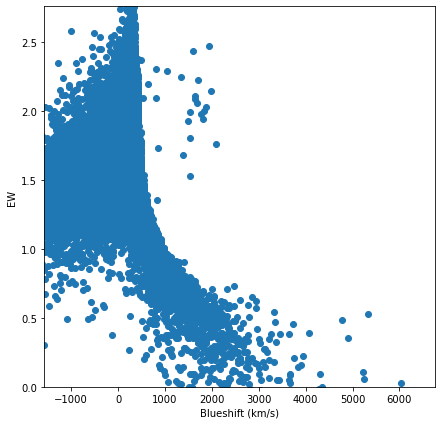

In [166]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(blue_list, np.log10(ew_list))
#ax.set_xlim(-500,5000)
ax.set_xlabel("Blueshift (km/s)")
ax.set_ylabel("EW")
#ax.set_yscale("log")
ax.set_xlim(-1577.0575829238915, 6752.935855052574)
ax.set_ylim(0.0, 2.762242337463174)
plt.show()

In [265]:
len(blue_list)

8368

In [268]:
len(dat.iloc[found])

8368

In [269]:
found

array([   0,    1,    2, ..., 8397, 8398, 8399])

In [275]:
np.array([np.array(dat.iloc[found]["name"])[np.array(blue_list)<-4000], np.array(blue_list)[np.array(blue_list)<-4000]]).T

array([['172858.16+603512.7', -5649.691184199695],
       ['135050.37+662910.6', -9231.230749590182],
       ['102214.76+021428.7', -6327.456050779935],
       ['103607.52+015659.0', -6625.699062649241],
       ['105704.19+030108.1', -6304.6724495879225],
       ['140821.66+025733.3', -6507.385050650054],
       ['142923.91+024023.1', -8373.040559877343],
       ['141927.49+044513.7', -5342.088933666452],
       ['150935.96+574300.5', -8648.570873877847],
       ['001741.87-105613.2', -6713.051956846002],
       ['003414.20-092738.7', -7179.950340194772],
       ['075551.44+352549.7', -7324.262237371567],
       ['152307.34+535358.2', -7909.309191632027],
       ['162501.98+430931.6', -8186.824798682457],
       ['090809.13+444138.8', -8118.804877281406],
       ['075331.84+270415.3', -5471.629305174152],
       ['103628.19+501157.8', -6033.44360386226],
       ['093217.06+415312.0', -8659.537254534582],
       ['103808.93+464249.2', -7137.9519384124],
       ['115757.24+505442.4', -59

Cell above never ended even though all the plots were done??  Fix this so I can actually save EW+blueshift!

In [496]:
CIV_data = np.array([blue_list, ew_list]).T
CIV_df   = pd.DataFrame(X_compressed, columns=["CIV_Blueshift_AE", "CIV_EW_AE"])
CIV_df.head()

(8368, 6)

---

Save a file with the latent parameters and reconstructions.

In [461]:
latent_params = pd.DataFrame(X_compressed, columns=["Latent{}".format(i) for i in range(1,7)])
latent_params.head()

Latent1    Latent2    Latent3    Latent4    Latent5     Latent6
0  10.995173 -24.321989 -86.158257 -23.353455 -23.098145  145.165146
1   3.507659 -15.365338 -41.509838  -8.665313 -19.529541   88.458229
2   2.539161  -4.128629 -97.612999 -20.272467  -3.241336  139.013672
3   4.729470 -16.875517 -40.656452 -10.279890 -16.192554   79.730820
4   6.467855 -15.585965 -41.874725 -15.720461 -12.612712   69.491760

In [462]:
sample_cut = dat.iloc[found]
sample_cut.shape

(8368, 65)

In [275]:
TSNE2 = pd.DataFrame(projTSNE2, columns=["TSNE_X", "TSNE_Y"])
TSNE2.head()

TSNE_X     TSNE_Y
0 -59.974598   5.428302
1  10.624625 -70.629379
2 -70.111412  -2.025018
3  24.048346 -53.701729
4  25.743031 -37.835445

In [276]:
df = pd.merge(sample_cut, latent_params, right_index=True, left_index=True)
df2= pd.merge(df, TSNE2, right_index=True, left_index=True)
df3= pd.merge(df2, CIV_df)
df2.head()

name        RA_1     Dec_1  REDSHIFT_1  PLATE_1  FIBER_1  \
0  095004.94-002012.2  147.520612 -0.336744      1.7756      267      275   
1  095938.28-003500.8  149.909527 -0.583571      1.8766      268       59   
2  101033.44-004724.5  152.639355 -0.790145      1.6675      270      213   
3  101100.92+002039.4  152.753859  0.344291      1.7487      270      491   
4  101826.85-000951.1  154.611911 -0.164201      1.8156      271      152   

   MJD_1  UNIFORM_TARGET_1    MI_Z2_1  LOGLBOL_1  ...  \
0  51608                 0 -27.635967  47.094489  ...   
1  51633                 0 -26.986037  46.849020  ...   
2  51909                 0 -27.539811  47.031922  ...   
3  51909                 0 -26.907112  46.713170  ...   
4  51883                 0 -27.177639  46.782514  ...   

                                         UGRIZ_DERED  DELTA_G_I    E_BV_2  \
0  (18.001000612974167, 17.926775991916656, 17.89...  -0.037049  0.069739   
1  (19.252000018954277, 18.74404826760292, 18.696...  -0.060394  0.035407   
2  (18.178000137209892, 18.07619148492813, 17.897...   0.209583  0.044319   
3  (18.662999659776688, 18.576296500861645, 18.58...  -0.121854  0.031931   
4  (18.50699943304062, 18.411264687776566, 18.418...  -0.134676  0.048818   

   Separation    Latent1     Latent2     Latent3    Latent4     TSNE_X  \
0    0.009446  47.630016  197.039566 -184.120697 -89.203102 -59.974598   
1    0.013102  36.250057  113.706329 -103.534317 -45.116665  10.624625   
2    0.012673  14.480593  204.195328 -176.934036 -88.136490 -70.111412   
3    0.005305  32.013721  105.890999  -96.678314 -44.374863  24.048346   
4    0.010948  27.914503   92.677177  -92.593033 -46.193886  25.743031   

      TSNE_Y  
0   5.428302  
1 -70.629379  
2  -2.025018  
3 -53.701729  
4 -37.835445  

[5 rows x 71 columns]

In [282]:
! ls ../../data/files/VLA2018b/

grdr7.8403col.radec.platemjdfiber.csv


In [283]:
df2.to_csv("grdr7.8403col.radec.platemjdfiber_w4LatentParams.csv")